# Model Optimization

In this notebook we will create a method that iterates through the possible ARIMA parameters (p,d,q) and measure the average mean absolute error (MAE) across a number of train-test splits conducted using a [rolling-window technique](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4). Doing so allows us to pick the best model based on the out-of-sample performance and will ensure our future predictions are as accurate as possible. 

After further investigation, not included in this notebook, we have decided to look into the following exogenous variables:

* 30-Day misdemeanor, violent felony, and nonviolent felony crime counts

* 30-Day misdemeanor, violent felony, and nonviolent felony arrest counts

* 30-Day Admissions to DOC.

Instead of feeding all of these variables into our final ARIMA model simultaneously, we will conduct a "funnel approach" which aims to replicate the way the criminal legal system operates. In that a crime occurs first, which may or may not be followed by an arrest, which may or may not be followed by detention (jail admission). This will help us minimize collinearity throughout the modelling process and will help us dictate whether or not these exogenous variables are increasing our predictive power by being compared to a model with the absense of exogenous variables.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.api import SARIMAX
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from pmdarima.arima import ndiffs, nsdiffs
from sklearn.model_selection import TimeSeriesSplit
import itertools

from functions import *
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Step 1: Get the data

In [5]:
#import data in question
_30day_pop_tot = pd.read_csv("../Data/_30_day_adp.csv", index_col = 0)
#specify data types for start and end date
_30day_pop_tot['Start Date'] = _30day_pop_tot['Start Date'].astype('datetime64[ns]')
_30day_pop_tot['End Date'] = _30day_pop_tot['End Date'].astype('datetime64[ns]')

_30day_pop_tot.head()

Start Date   End Date     ADP
0 2016-05-15 2016-06-13  9820.0
1 2016-06-14 2016-07-13  9796.0
2 2016-07-14 2016-08-12  9730.0
3 2016-08-13 2016-09-11  9824.0
4 2016-09-12 2016-10-11  9845.0

In [6]:
joined_doc_ivs_df = pd.read_csv("../Data/_30_day_IVs.csv", index_col = 0)
#specify data types for start and end date
joined_doc_ivs_df['Start Date'] = joined_doc_ivs_df['Start Date'].astype('datetime64[ns]')
joined_doc_ivs_df['End Date'] = joined_doc_ivs_df['End Date'].astype('datetime64[ns]')
joined_doc_ivs_df.head()

Start Date   End Date  admission_count  discharge_count  Avg LOS Days
0 2016-05-15 2016-06-13             4935             4880     56.661485
1 2016-06-14 2016-07-13             4897             4999     62.825000
2 2016-07-14 2016-08-12             4871             4874     61.316523
3 2016-08-13 2016-09-11             4600             4338     56.608826
4 2016-09-12 2016-10-11             4519             4666     61.751337

In [7]:
crime_data = pd.read_csv("../Data/_30_day_crime_counts.csv", index_col = 0)
#specify data types for start and end date
crime_data['Start Date'] = crime_data['Start Date'].astype('datetime64[ns]')
crime_data['End Date'] = crime_data['End Date'].astype('datetime64[ns]')

#get arrest data
arrest_data = pd.read_csv("../Data/_30_day_arrest_counts.csv", index_col = 0)
#specify data types for start and end date
arrest_data['Start Date'] = arrest_data['Start Date'].astype('datetime64[ns]')
arrest_data['End Date'] = arrest_data['End Date'].astype('datetime64[ns]')


We know that these datasets have in-compatible lengths due to a lag in DOC and NYPD data practices.

In [8]:
print(len(crime_data),len(arrest_data),len(joined_doc_ivs_df),len(_30day_pop_tot))

98 98 101 102


We will have to determine how many predictions we will make for each group of variables based on the length of ADP signal.

We know that ADP needs to be projected 12 steps into the future. So each signal needs to be predicted 12 steps plus any missing data values.

In [9]:
n_steps_crime = 12 + len(_30day_pop_tot) - len(crime_data)
n_steps_arr = 12 + len(_30day_pop_tot) - len(arrest_data)
n_steps_adm = 12 + len(_30day_pop_tot) - len(joined_doc_ivs_df)
n_steps_adp = 12

print(n_steps_crime,n_steps_arr,n_steps_adm,n_steps_adp)

16 16 13 12


In [10]:
#join all variables of interest into one dataframe
crime_cols = ['Start Date', 'End Date', 'total_felony_crimes',
              'violent_felony_crimes','nonviolent_felony_crimes', 'total_misdemeanor_crimes']
arr_cols = ['Start Date', 'End Date', 'total_felony_arrest',
            'violent_felony_arrest','nonviolent_felony_arrest', 'total_misdemeanor_arrest']

#join adp and crime data
joined_df = _30day_pop_tot.merge(crime_data[crime_cols],
                                 how = 'left',
                                 left_on= ['Start Date', 'End Date'],
                                 right_on= ['Start Date', 'End Date'])
#join arrests
joined_df = joined_df.merge(arrest_data[arr_cols],
                                 how = 'left',
                                 left_on= ['Start Date', 'End Date'],
                                 right_on= ['Start Date', 'End Date'])
#join admission count
joined_df = joined_df.merge(joined_doc_ivs_df[['Start Date', 'End Date','admission_count']],
                            how = 'left',
                            left_on= ['Start Date', 'End Date'],
                            right_on= ['Start Date', 'End Date']
                            )

joined_df.head()

Start Date   End Date     ADP  total_felony_crimes  violent_felony_crimes  \
0 2016-05-15 2016-06-13  9820.0              12504.0                 3330.0   
1 2016-06-14 2016-07-13  9796.0              12792.0                 3422.0   
2 2016-07-14 2016-08-12  9730.0              13079.0                 3588.0   
3 2016-08-13 2016-09-11  9824.0              13320.0                 3530.0   
4 2016-09-12 2016-10-11  9845.0              12309.0                 3160.0   

   nonviolent_felony_crimes  total_misdemeanor_crimes  total_felony_arrest  \
0                    9174.0                   23148.0               7890.0   
1                    9370.0                   22376.0               7647.0   
2                    9491.0                   22312.0               7849.0   
3                    9790.0                   22284.0               7812.0   
4                    9149.0                   21337.0               7582.0   

   violent_felony_arrest  nonviolent_felony_arrest  total_misdemeanor_arrest  \
0                 2353.0                    5537.0                   17655.0   
1                 2332.0                    5315.0                   16604.0   
2                 2465.0                    5384.0                   15893.0   
3                 2334.0                    5478.0                   16682.0   
4                 2187.0                    5395.0                   16690.0   

   admission_count  
0           4935.0  
1           4897.0  
2           4871.0  
3           4600.0  
4           4519.0

In [11]:
joined_df.tail()

Start Date   End Date     ADP  total_felony_crimes  violent_felony_crimes  \
97  2024-05-03 2024-06-01  6313.0              15032.0                 4169.0   
98  2024-06-02 2024-07-01  6383.0                  NaN                    NaN   
99  2024-07-02 2024-07-31  6387.0                  NaN                    NaN   
100 2024-08-01 2024-08-30  6443.0                  NaN                    NaN   
101 2024-08-31 2024-09-29  6509.0                  NaN                    NaN   

     nonviolent_felony_crimes  total_misdemeanor_crimes  total_felony_arrest  \
97                    10863.0                   24261.0               8977.0   
98                        NaN                       NaN                  NaN   
99                        NaN                       NaN                  NaN   
100                       NaN                       NaN                  NaN   
101                       NaN                       NaN                  NaN   

     violent_felony_arrest  nonviolent_felony_arrest  \
97                  3008.0                    5969.0   
98                     NaN                       NaN   
99                     NaN                       NaN   
100                    NaN                       NaN   
101                    NaN                       NaN   

     total_misdemeanor_arrest  admission_count  
97                    12049.0           1979.0  
98                        NaN           2011.0  
99                        NaN           1903.0  
100                       NaN           2005.0  
101                       NaN              NaN

In [12]:
joined_df.columns

Index(['Start Date', 'End Date', 'ADP', 'total_felony_crimes',
       'violent_felony_crimes', 'nonviolent_felony_crimes',
       'total_misdemeanor_crimes', 'total_felony_arrest',
       'violent_felony_arrest', 'nonviolent_felony_arrest',
       'total_misdemeanor_arrest', 'admission_count'],
      dtype='object')

## Step 2: Time Series Analysis

I will log-transform all of my series before analyzing and during the fit process. I am doing this to ensure all predicted values remain non-negative since we are handling population count data. I will then define two UDFs that conduct a grid search & rolling window cross validation technique to find the SARIMA paramters that minimize OOS mean absolute error.

Another important tool to evaluate the model is the analysis of the residual test statistics in the results summary.

Now we print the summaries of each model and evaluate Prob(Q) and Prob(JB) applying, respectively, the following tests:

**Ljung–Box test:**

Null hypothesis: There are no correlations in the residuals.

**Jarque–Bera test:**

Null hypothesis: Residuals are normally distributed.

In [13]:
# Ensure non-negative values by applying a log transformation
def log_transform(series):
    return np.log1p(series)

def inverse_log_transform(series):
    return np.expm1(series)

In [14]:
#UDF 1
def time_series_cv(y, order, seasonal_order, n_splits, exog=None):
    """
    Parameters:
    -----------
    y: array
    order: tuple
    seasonal_order: tuple
    n_splits: int
    exog: array, Default = None

    Output:
    -------
    results: Results object holding results from fitting a state space model.
    np.mean(mae_scores): float
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mae_scores = []

    for train_index, test_index in tscv.split(y):
        train_y, test_y = y[train_index], y[test_index]
        train_exog = exog.iloc[train_index] if exog is not None else None
        test_exog = exog.iloc[test_index] if exog is not None else None
        
        model = SARIMAX(train_y, exog=train_exog, order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False)
        
        predictions = results.predict(start=test_index[0], end=test_index[-1], exog=test_exog)
        mae = mean_absolute_error(inverse_log_transform(test_y), inverse_log_transform(predictions))
        mae_scores.append(mae)
        
    return results, np.mean(mae_scores)

def grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits, exog=None):
    """
    Parameters:
    -----------
    y: array
    p_values: tuple
    q_values: tuple
    P_values: tuple
    Q_values: tuple
    s: int
    n_splits: int
    exog: array, Default = None

    Output:
    -------
    best_result: Results object holding results from fitting a state space model.
    best_params: tuple
    best_score: float
    """
    best_score, best_params = float("inf"), None
    
    d_value = ndiffs(y.dropna(), test='adf')
    D_value = nsdiffs(y.dropna(), m=s)
    pdq = list(itertools.product(p_values, [d_value], q_values))
    seasonal_pdq = list(itertools.product(P_values, [D_value], Q_values, [s]))
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                results, mae_score = time_series_cv(y, order=param, seasonal_order=param_seasonal, n_splits=n_splits, exog=exog)
                if mae_score < best_score:
                    best_score, best_params = mae_score, (param, param_seasonal)
                    best_result = results
            except:
                continue
                
    print(best_result.summary())
    return best_result, best_params, best_score


### Crime Metrics

In [15]:
# Define the crime variables
crime_vars = ['total_felony_crimes', 'violent_felony_crimes', 'nonviolent_felony_crimes', 'total_misdemeanor_crimes']
crime_df = joined_df[['End Date']+crime_vars].dropna()
crime_df.set_index('End Date', inplace=True)

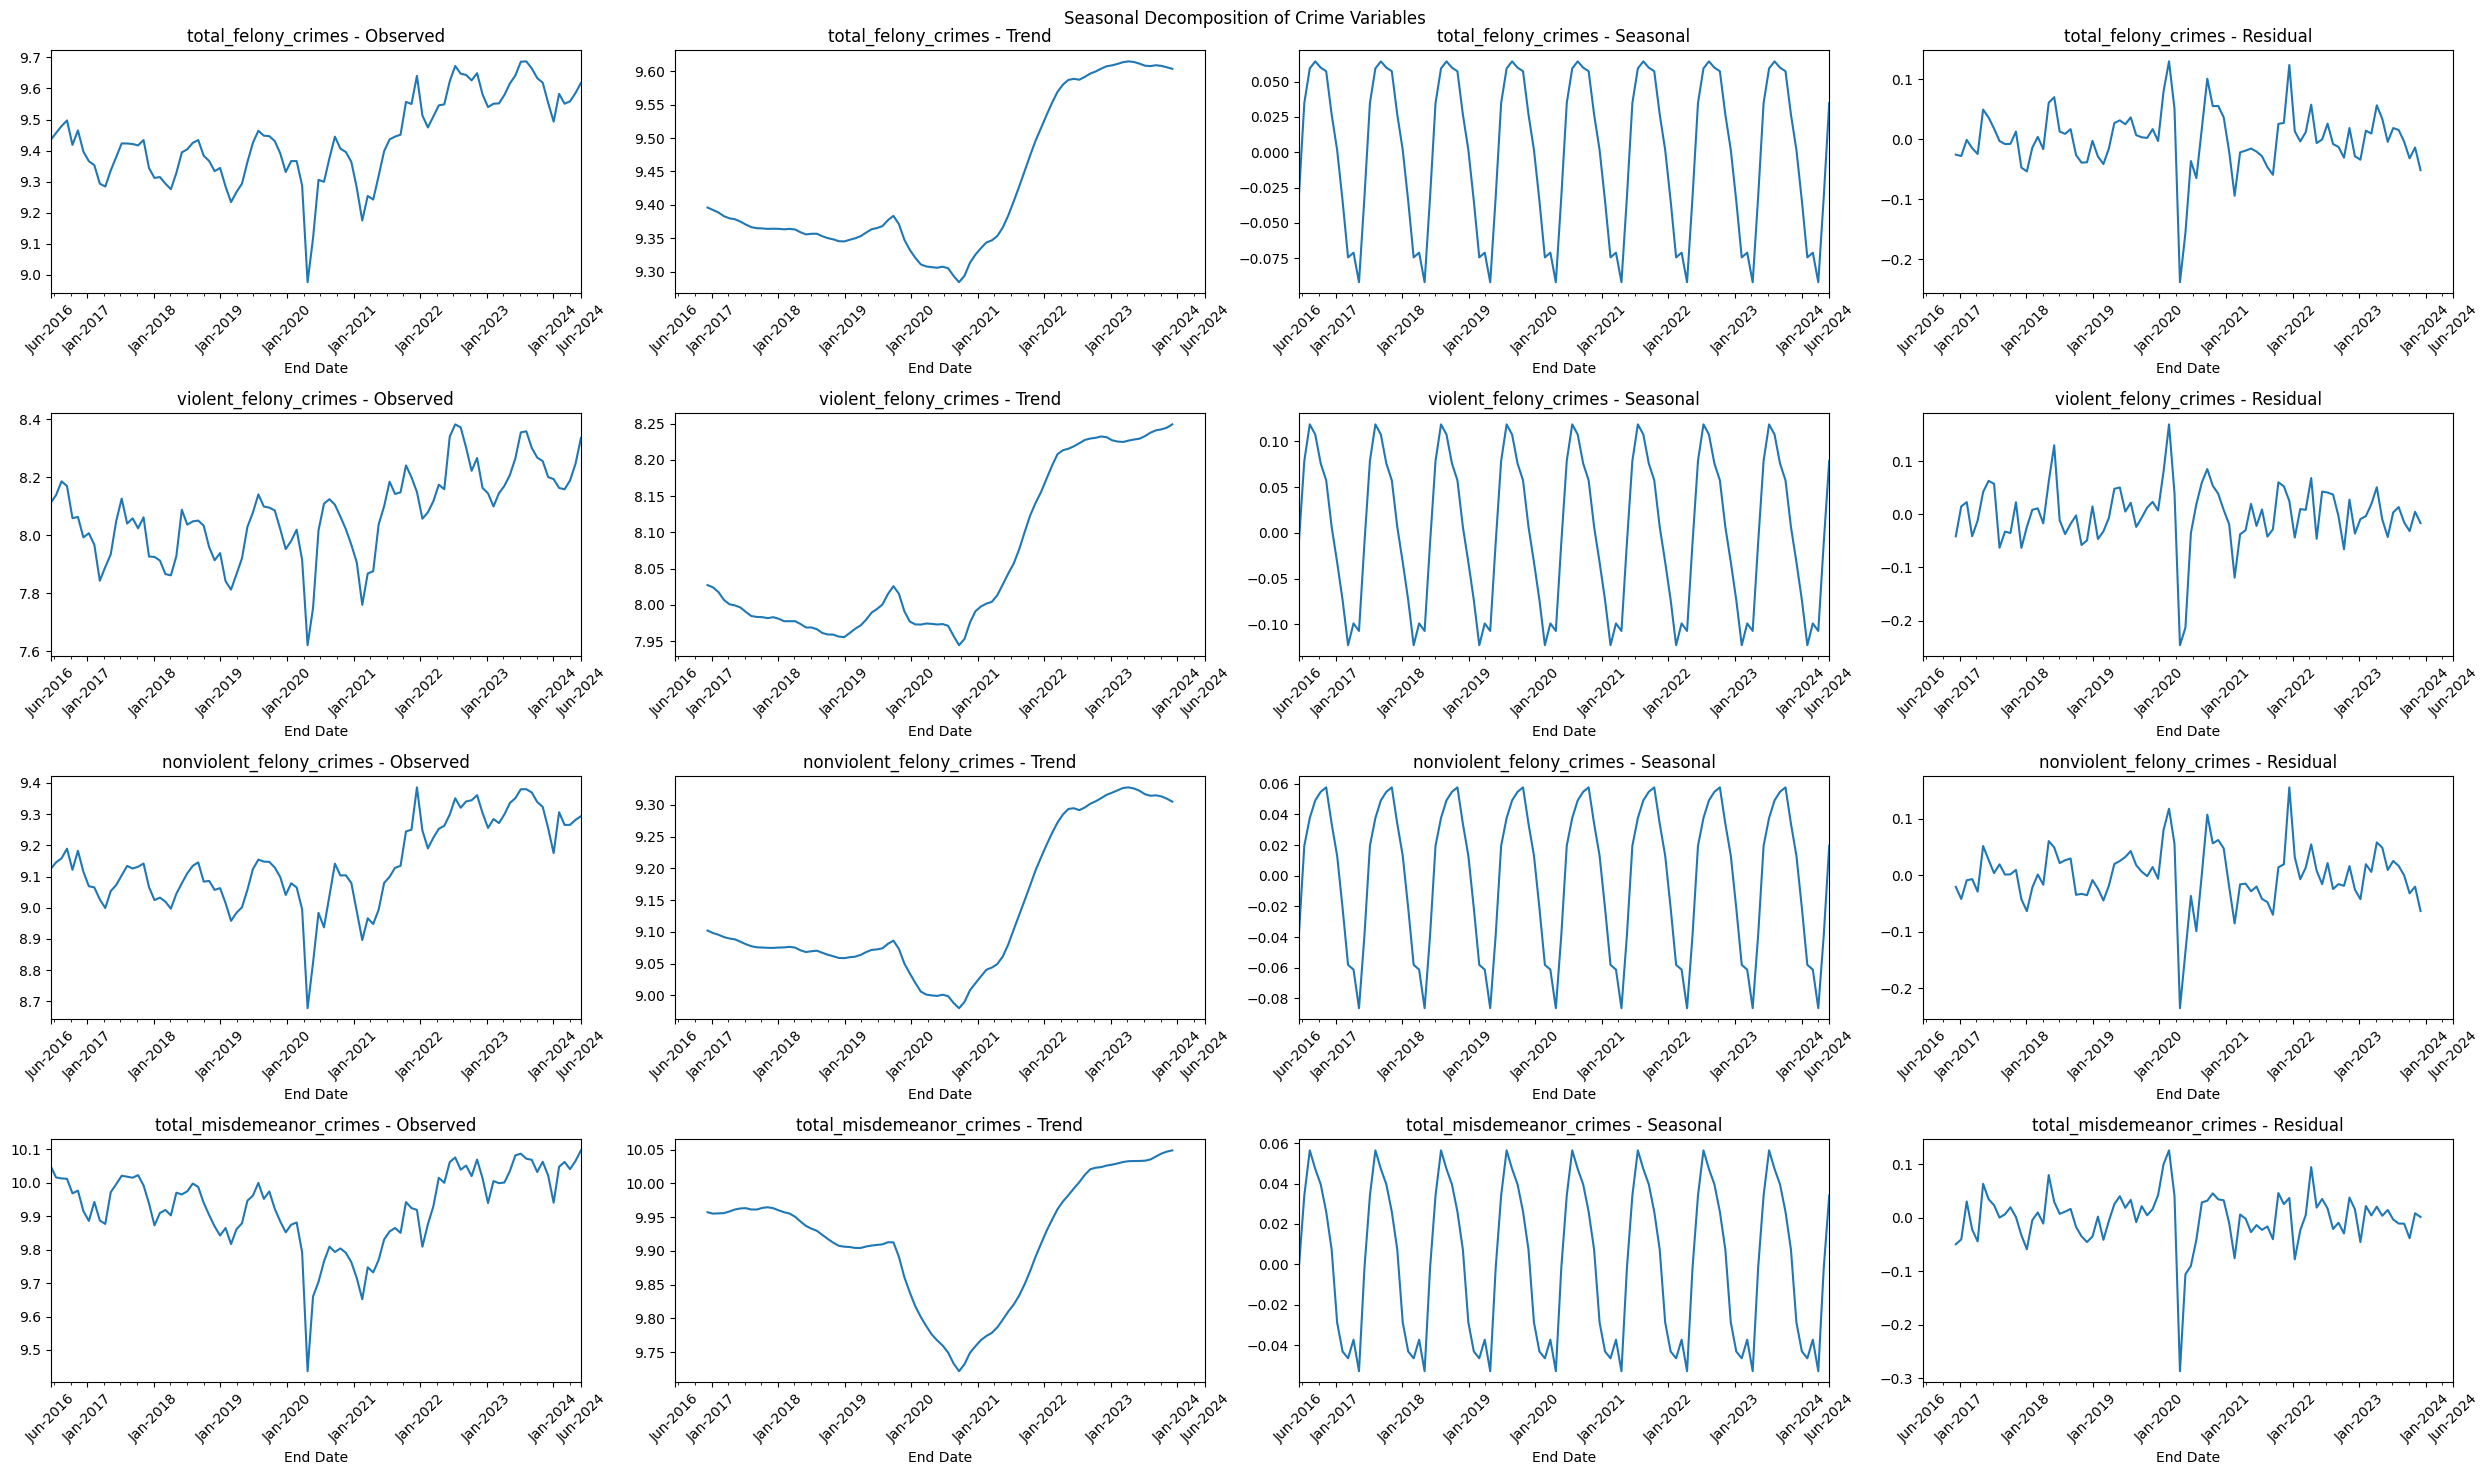

In [16]:
#plot seasonal decompose of crime vars

# Set up the figure with a 4x4 grid of subplots
fig, axes = plt.subplots(len(crime_vars), 4, figsize=(25, 15))

# Iterate through each crime variable
for i, var in enumerate(crime_vars):
    # Perform seasonal decomposition
    result = seasonal_decompose(log_transform(crime_df[var].dropna()), model='additive', period=12)  # Adjust 'period' according to your data
    
    # Plot each component in a separate subplot
    result.observed.plot(ax=axes[i, 0], legend=False, title=f'{var} - Observed')
    result.trend.plot(ax=axes[i, 1], legend=False, title=f'{var} - Trend')
    result.seasonal.plot(ax=axes[i, 2], legend=False, title=f'{var} - Seasonal')
    result.resid.plot(ax=axes[i, 3], legend=False, title=f'{var} - Residual')

    for j in range(4):
        axes[i, j].set_xlabel('End Date')
        axes[i, j].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b-%Y'))
        axes[i, j].tick_params(axis='x', rotation=45)

# Adjust layout
plt.suptitle('Seasonal Decomposition of Crime Variables')
plt.tight_layout()
plt.savefig('../Outputs/crime_exog_decomposed_components_plots_30days.png', bbox_inches = 'tight')
plt.show()

In [17]:
for i, var in enumerate(crime_vars):
    signal = log_transform(crime_df[var].dropna())
    #determine non-seasonal and seasonal differencing orders
    d = ndiffs(signal, test='adf')
    D = nsdiffs(signal, m = 12, max_D=2)
    print(f'The difference cofficient for {var} is {d} and the seasonal difference is {D}')

The difference cofficient for total_felony_crimes is 1 and the seasonal difference is 0
The difference cofficient for violent_felony_crimes is 0 and the seasonal difference is 0
The difference cofficient for nonviolent_felony_crimes is 1 and the seasonal difference is 0
The difference cofficient for total_misdemeanor_crimes is 1 and the seasonal difference is 0


Based on the outputs below, the only signal without a differencing coefficient should be violent felony crimes.

In [18]:
# Define the ranges for the parameters. We are going to limit the max number for out params to limit over fitting
p_values = range(0, 4)
q_values = range(0, 4)
P_values = range(0, 2)
Q_values = range(0, 2)
s = 12  # Season length, e.g., 12 for yearly seasonality in monthly data

n_splits = 10  # Define the number of splits for TimeSeriesSplit

In [19]:
crime_cv_results = {}

#iterate through the vars
for var in crime_vars:
    print(f'Fitting {var} variable')
    y = crime_df[var].dropna()
    y = log_transform(y)
    # Perform grid search with time series cross-validation
    best_result, best_params, best_score = grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits)
    crime_cv_results[var] = {'result': best_result, 'model params': best_params, 'mae': best_score}
    print(f'Best SARIMAX parameters: {best_params} with MAE: {best_score}')

Fitting total_felony_crimes variable
                                      SARIMAX Results                                       
Dep. Variable:                  total_felony_crimes   No. Observations:                   90
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 12)   Log Likelihood                 126.783
Date:                              Tue, 01 Oct 2024   AIC                           -237.567
Time:                                      12:31:00   BIC                           -217.658
Sample:                                  06-13-2016   HQIC                          -229.542
                                       - 10-05-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0678      0.212     -0.320      0.749      -

In [20]:
crime_cv_results

{'total_felony_crimes': {'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d73cf30150>,
  'model params': ((2, 1, 3), (1, 0, 1, 12)),
  'mae': 800.1009121532861},
 'violent_felony_crimes': {'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d73ce0fa10>,
  'model params': ((1, 0, 2), (1, 0, 1, 12)),
  'mae': 246.62439159653132},
 'nonviolent_felony_crimes': {'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d73cd32fd0>,
  'model params': ((1, 1, 1), (1, 0, 0, 12)),
  'mae': 619.2193556954468},
 'total_misdemeanor_crimes': {'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d739c8e690>,
  'model params': ((1, 1, 3), (0, 0, 0, 12)),
  'mae': 1419.2204414254581}}

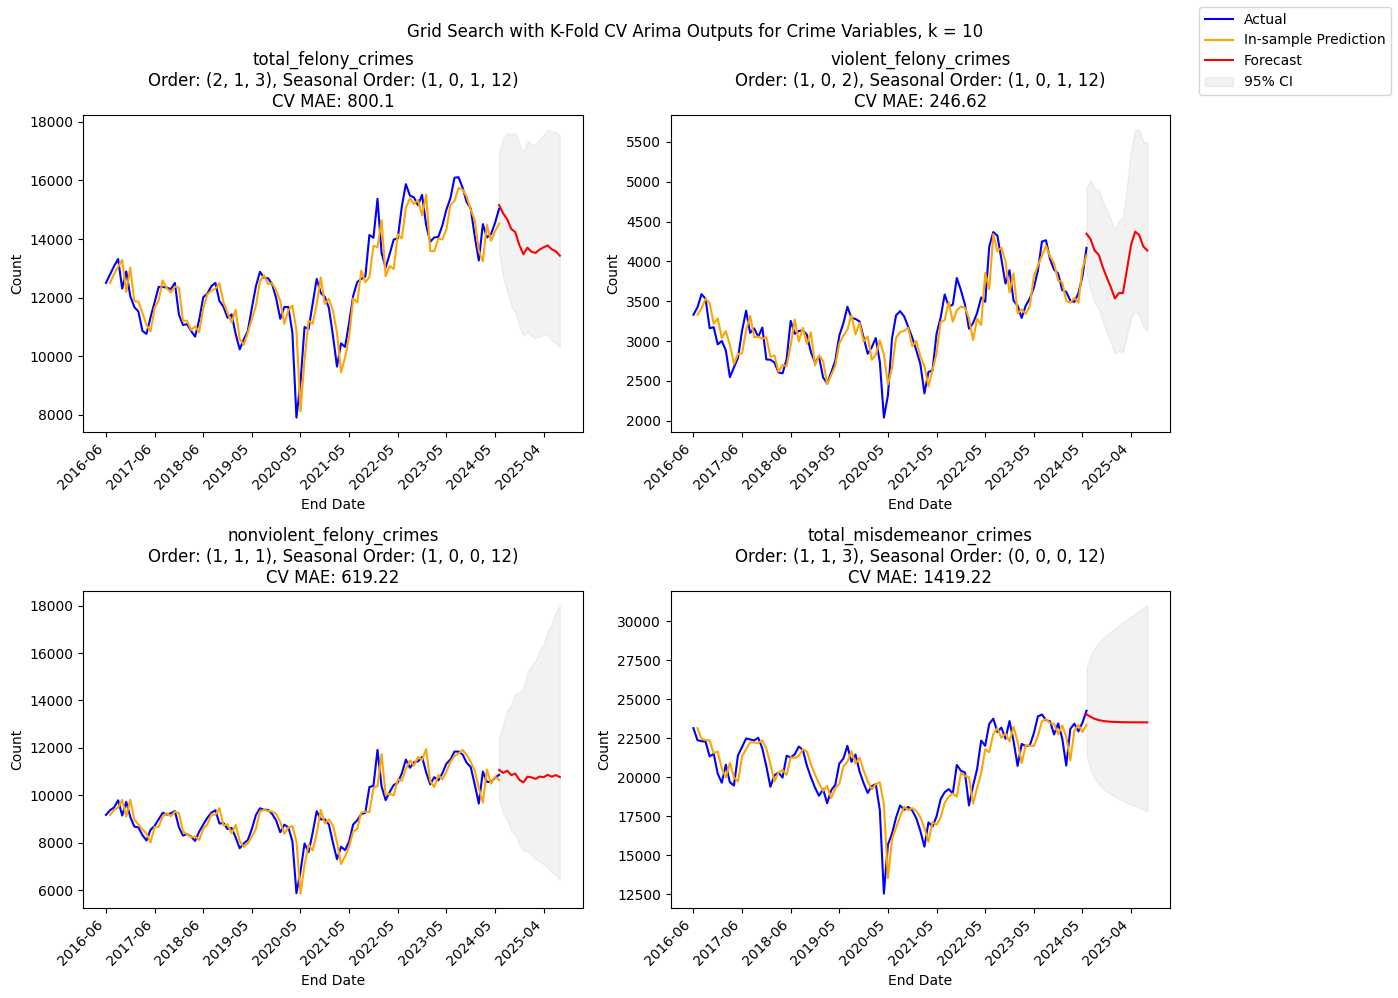

In [21]:
#plot outputs
# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Plot each crime variable
for i, var in enumerate(crime_vars):
    ax = axes[i]
    data = crime_df[var].dropna()
    y = log_transform(data)
    order = crime_cv_results[var]['model params'][0]
    seasonal_order = crime_cv_results[var]['model params'][1]
    cv_mae = crime_cv_results[var]['mae']

    model = SARIMAX(y, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
        
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    # Generate out-of-sample forecast_exog
    forecast_log = results.get_forecast(steps=n_steps_crime)
    y_forecast_log = forecast_log.predicted_mean
    conf_int_log = forecast_log.conf_int()

    # Bias-adjusted mean forecast back-transformation
    forecast = inverse_log_transform(y_forecast_log)
    #store in dictionary
    crime_cv_results[var]['predictions'] = forecast.values
    # Back-transform confidence intervals
    lower_bound = inverse_log_transform(conf_int_log.iloc[:, 0])
    upper_bound = inverse_log_transform(conf_int_log.iloc[:, 1])

    mae = mean_absolute_error(data,y_pred)

    # Plot the actual data
    ax.plot(data.index, data, label='Actual', color='blue')

    # Plot the in-sample prediction
    ax.plot(data.index[1:], y_pred[1:], label='In-sample Prediction', color='orange')

    # Plot the forecast
    future_dates = pd.date_range(start=data.index[-1], periods=n_steps_crime, freq='30D')
    ax.plot(future_dates, forecast, label='Forecast', color='red')

    # Plot the confidence intervals
    ax.fill_between(future_dates, lower_bound, upper_bound, color='grey', alpha=0.1, label='95% CI')
    
    # Set title and labels, including model parameters
    title = f"{var}\nOrder: {order}, Seasonal Order: {seasonal_order}\nCV MAE: {round(cv_mae,2)}"
    ax.set_title(title)
    ax.set_xlabel('End Date')
    ax.set_ylabel('Count')

    # Set x-ticks and rotate labels
    dates = pd.date_range(start=data.index[0], periods=len(data)+n_steps_crime, freq='30D')

    ax.set_xticks(dates[::12])
    ax.set_xticklabels(dates[::12].strftime('%Y-%m'), rotation=45, ha='right')

# Create a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle(f"Grid Search with K-Fold CV Arima Outputs for Crime Variables, k = {n_splits}")

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the legend
plt.savefig("../Outputs/grid_search_kfold_cv_crime_predictions.png", bbox_inches = 'tight')
plt.show()

Now let's plot the residual plots for each of these models

Computed the residuals for total_felony_crimes
Done plotting subplots for total_felony_crimes
Computed the residuals for violent_felony_crimes
Done plotting subplots for violent_felony_crimes
Computed the residuals for nonviolent_felony_crimes
Done plotting subplots for nonviolent_felony_crimes
Computed the residuals for total_misdemeanor_crimes
Done plotting subplots for total_misdemeanor_crimes


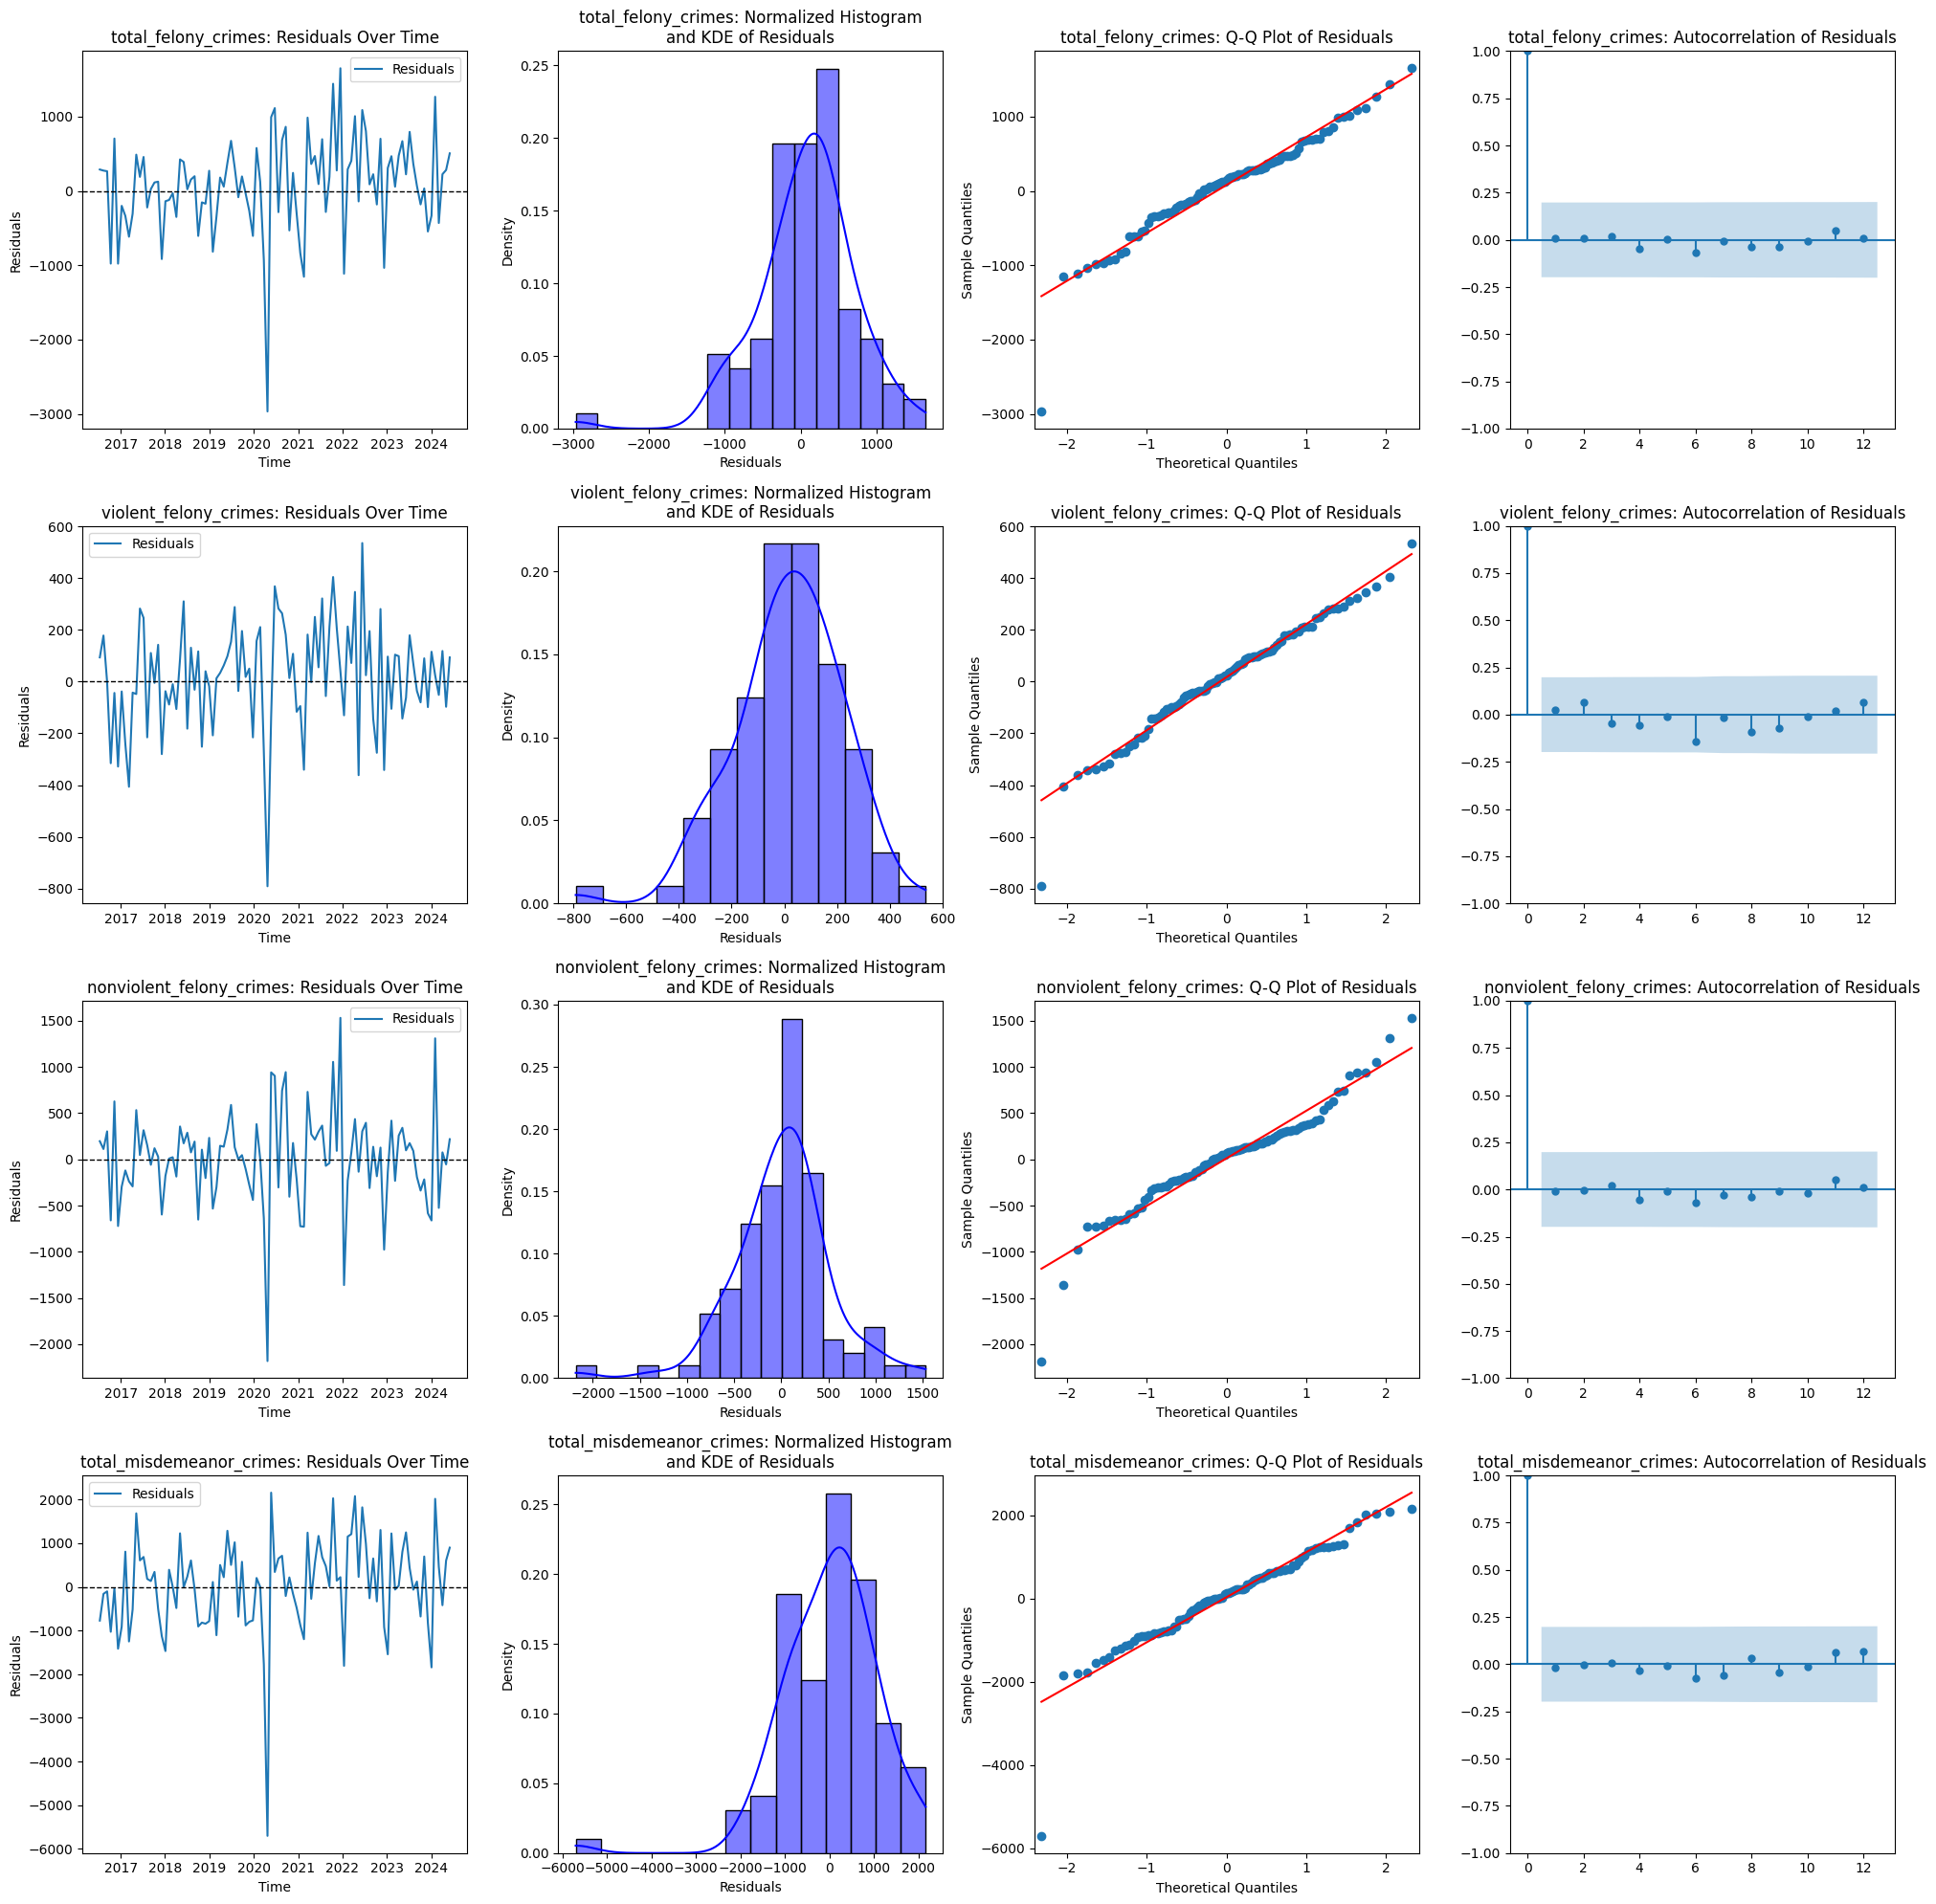

In [22]:
# Create auto_arima model
#iterate through crime variables and store output in new dictionary
auto_arima_dict = {}
fig, axs = plt.subplots(len(crime_vars), 4, figsize=(20, 5 * len(crime_vars)))

for i, var in enumerate(crime_vars):
    data = crime_df[var].dropna()
    y = log_transform(data)
    order = crime_cv_results[var]['model params'][0]
    seasonal_order = crime_cv_results[var]['model params'][1]
    cv_mae = crime_cv_results[var]['mae']

    model = SARIMAX(y, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
        
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    # Calculate residuals
    residuals = crime_df[var].dropna() - y_pred
    
    #plot residual diagnostics
    print(f'Computed the residuals for {var}')
    # Residuals over time
    axs[i, 0].plot(residuals.index[1:], residuals[1:], label='Residuals')
    axs[i, 0].axhline(0, linestyle='--', color='black', linewidth=1)
    axs[i, 0].set_title(f'{var}: Residuals Over Time')
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].set_ylabel('Residuals')
    axs[i, 0].legend()
    
    # Histogram and KDE plot of residuals
    sns.histplot(residuals[1:], kde=True,stat='probability', ax=axs[i, 1], color='blue')
    axs[i, 1].set_title(f'{var}: Normalized Histogram\nand KDE of Residuals')
    axs[i, 1].set_xlabel('Residuals')
    axs[i, 1].set_ylabel('Density')
    
    # Q-Q plot of residuals
    sm.qqplot(residuals[1:], line='s', ax=axs[i, 2])
    axs[i, 2].set_title(f'{var}: Q-Q Plot of Residuals')
    
    # ACF plot of residuals
    sm.graphics.tsa.plot_acf(residuals, lags=12, ax=axs[i, 3])
    axs[i, 3].set_title(f'{var}: Autocorrelation of Residuals')
    print(f'Done plotting subplots for {var}')
# Adjust layout to avoid overlapping
plt.tight_layout()
plt.savefig('../Outputs/crime_predictions_residual_plots.png', bbox_inches = 'tight')
plt.show()

I like these results. There seems to be a bit of over fitting based on the QQ plot but I think it is suitable for our use case. Now we will do the same but with the arrest variables and use the crime variables as exogenous vars.

### Arrest Metrics

In [23]:
#specify arrest vars and data
# Define the crime variables
arrest_vars = {
    'total_felony_arrest': 'total_felony_crimes',
    'violent_felony_arrest': 'violent_felony_crimes',
    'nonviolent_felony_arrest': 'nonviolent_felony_crimes',
    'total_misdemeanor_arrest': 'total_misdemeanor_crimes'
}
arrest_df = joined_df[['End Date']+list(arrest_vars.keys())].dropna()
arrest_df.set_index('End Date', inplace=True)

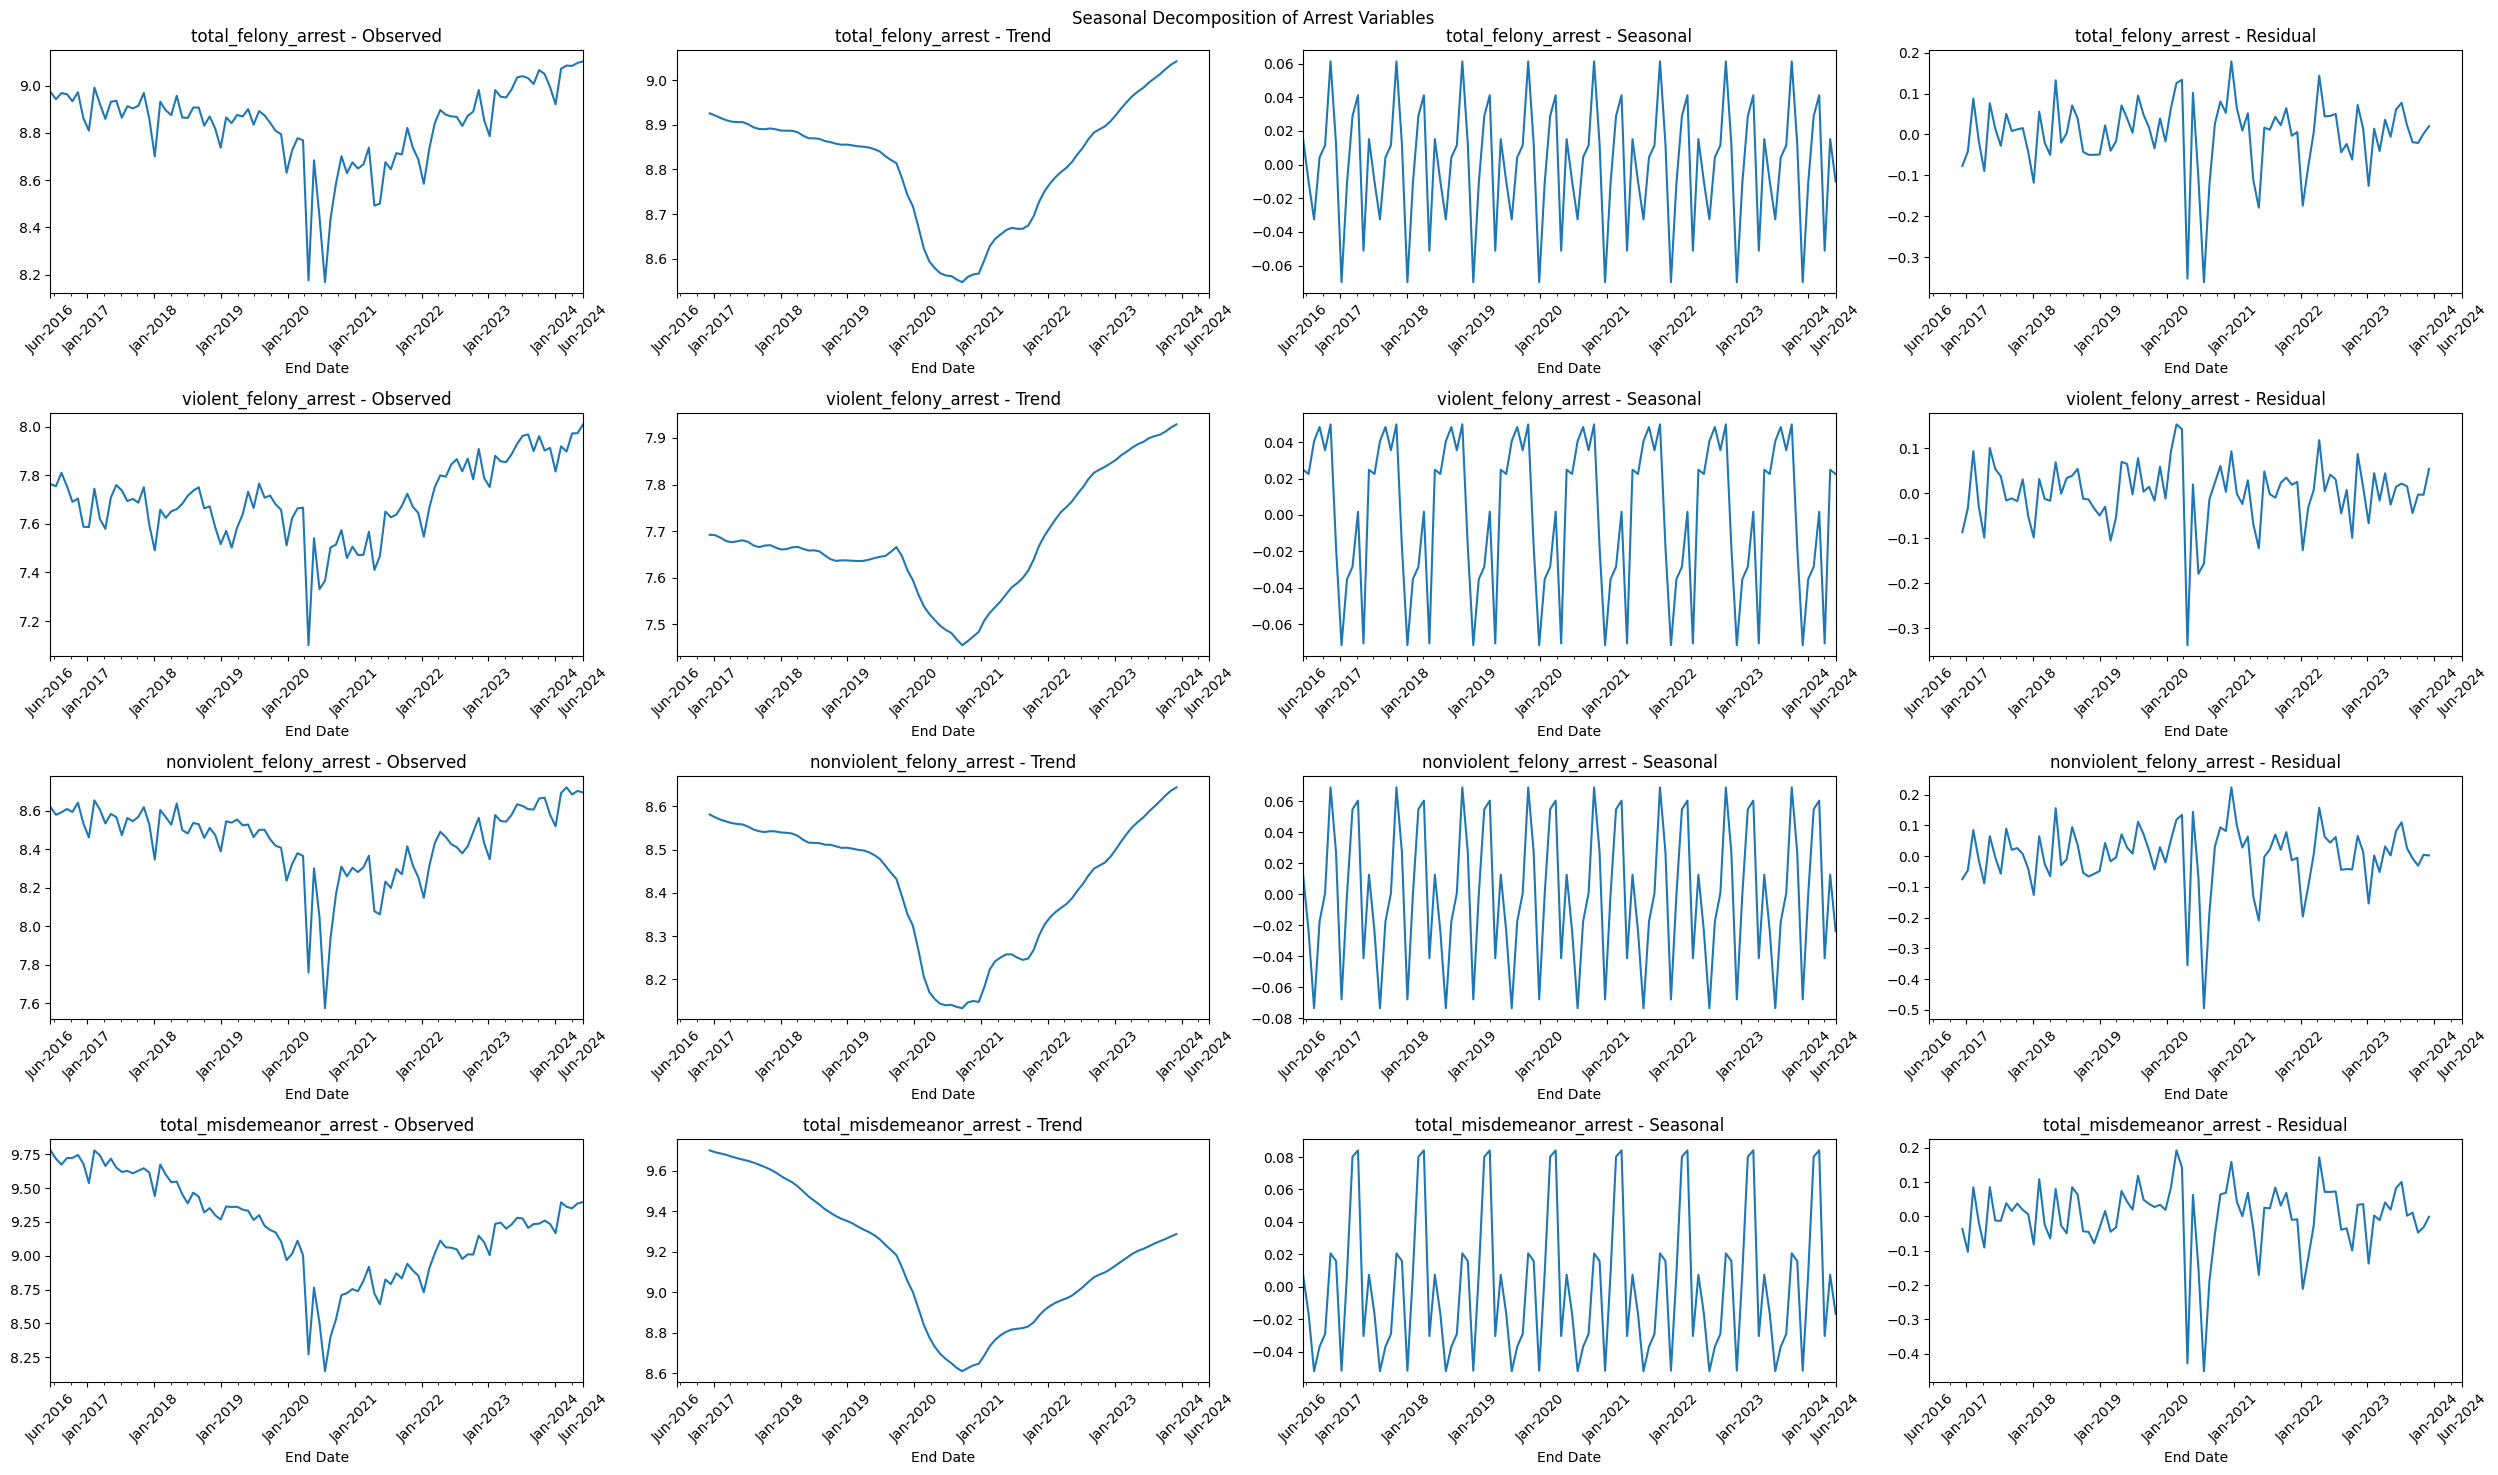

In [24]:

# Set up the figure with a 4x4 grid of subplots
fig, axes = plt.subplots(len(arrest_vars), 4, figsize=(25, 15))

# Iterate through each crime variable
for i, var in enumerate(arrest_vars):
    # Perform seasonal decomposition
    result = seasonal_decompose(log_transform(arrest_df[var].dropna()), model='additive', period=12)  # Adjust 'period' according to your data
    
    # Plot each component in a separate subplot
    result.observed.plot(ax=axes[i, 0], legend=False, title=f'{var} - Observed')
    result.trend.plot(ax=axes[i, 1], legend=False, title=f'{var} - Trend')
    result.seasonal.plot(ax=axes[i, 2], legend=False, title=f'{var} - Seasonal')
    result.resid.plot(ax=axes[i, 3], legend=False, title=f'{var} - Residual')

    for j in range(4):
        axes[i, j].set_xlabel('End Date')
        axes[i, j].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b-%Y'))
        axes[i, j].tick_params(axis='x', rotation=45)

# Adjust layout
plt.suptitle('Seasonal Decomposition of Arrest Variables')
plt.tight_layout()
plt.savefig('../Outputs/arrest_exog_decomposed_components_plots_30days.png', bbox_inches = 'tight')
plt.show()

In [25]:
# Find and evaluate SARIMA models for each arrest variable with exogenous crime variables
arrest_cv_models = {}

for arrest_var, exog_var in arrest_vars.items():
    y = log_transform(arrest_df[arrest_var].dropna())
    exog = log_transform(crime_df[exog_var].dropna())
    
    # Ensure the exog variable has the same index as the target variable
    exog = exog.loc[y.index]
    
    best_result, best_params, best_score = grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits, exog=exog)
    
    arrest_cv_models[arrest_var] = {'exog' : exog_var, 'result': best_result, 'model params': best_params, 'mae': best_score}
    print(f"Best model for {arrest_var}: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

                                     SARIMAX Results                                      
Dep. Variable:                total_felony_arrest   No. Observations:                   90
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 12)   Log Likelihood                  81.011
Date:                            Tue, 01 Oct 2024   AIC                           -152.023
Time:                                    13:05:58   BIC                           -139.579
Sample:                                06-13-2016   HQIC                          -147.007
                                     - 10-05-2023                                         
Covariance Type:                              opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
total_felony_crimes     0.6076      0.072      8.479      0.000       0.467       0.748
ar.L1   

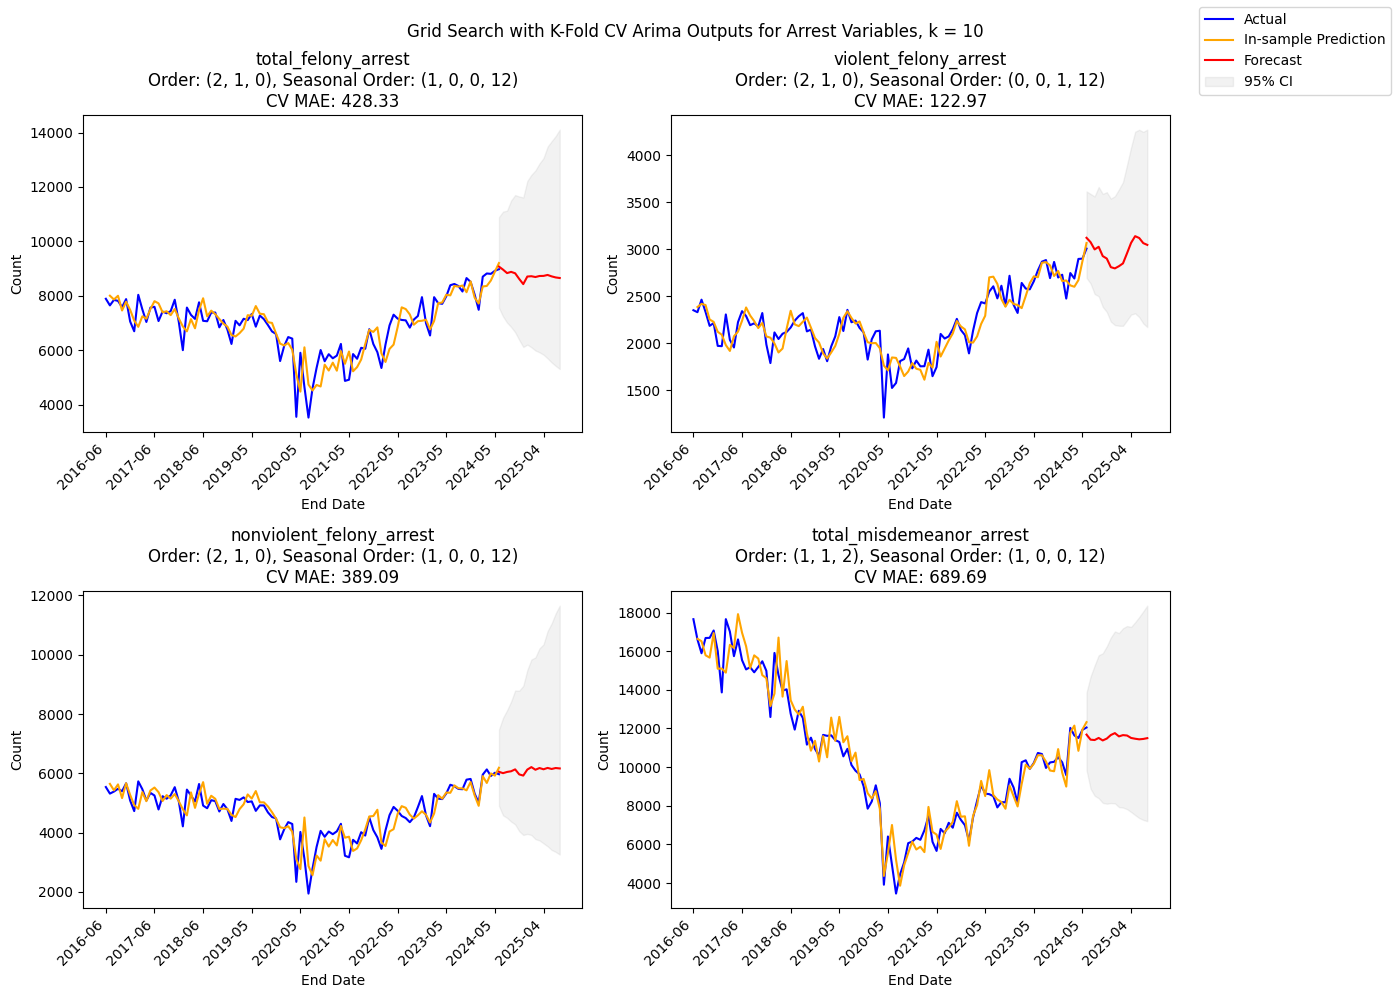

In [26]:
#plot
#plot outputs
# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Plot each crime arrest_variable

for i, (arrest_var, exog_var) in enumerate(arrest_vars.items()):
    ax = axes[i]
    data = arrest_df[arrest_var].dropna()
    exog = log_transform(crime_df[exog_var].dropna())
    y = log_transform(data)
    # Ensure the exog arrest_variable has the same index as the target arrest_variable
    exog = exog.loc[y.index]

    order = arrest_cv_models[arrest_var]['model params'][0]
    seasonal_order = arrest_cv_models[arrest_var]['model params'][1]
    cv_mae = arrest_cv_models[arrest_var]['mae']

    model = SARIMAX(y,exog = exog, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    
    #get exog_preds
    exog_forecast = crime_cv_results[exog_var]['predictions']
    exog_forecast_log = log_transform(exog_forecast)
    
    #now predict target var
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    # Generate out-of-sample forecast_exog
    forecast_log = results.get_forecast(steps=n_steps_arr, exog = exog_forecast_log)
    y_forecast_log = forecast_log.predicted_mean
    conf_int_log = forecast_log.conf_int()

    # Bias-adjusted mean forecast back-transformation
    forecast = inverse_log_transform(y_forecast_log)

    # Back-transform confidence intervals
    lower_bound = inverse_log_transform(conf_int_log.iloc[:, 0])
    upper_bound = inverse_log_transform(conf_int_log.iloc[:, 1])

    IS_mae = mean_absolute_error(data.iloc[1:],y_pred.iloc[1:])

    # Plot the actual data
    ax.plot(data.index, data, label='Actual', color='blue')

    # Plot the in-sample prediction
    ax.plot(data.index[1:], y_pred[1:], label='In-sample Prediction', color='orange')

    # Plot the forecast
    future_dates = pd.date_range(start=data.index[-1], periods=n_steps_arr, freq='30D')
    ax.plot(future_dates, forecast, label='Forecast', color='red')

    # Plot the confidence intervals
    ax.fill_between(future_dates, lower_bound, upper_bound, color='grey', alpha=0.1, label='95% CI')
    
    # Set title and labels, including model parameters
    title = f"{arrest_var}\nOrder: {order}, Seasonal Order: {seasonal_order}\nCV MAE: {round(cv_mae,2)}"
    ax.set_title(title)
    ax.set_xlabel('End Date')
    ax.set_ylabel('Count')

    # Set x-ticks and rotate labels
    dates = pd.date_range(start=data.index[0], periods=len(data)+n_steps_arr, freq='30D')

    ax.set_xticks(dates[::12])
    ax.set_xticklabels(dates[::12].strftime('%Y-%m'), rotation=45, ha='right')

# Create a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle(f"Grid Search with K-Fold CV Arima Outputs for Arrest Variables, k = {n_splits}")

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the legend
plt.savefig("../Outputs/grid_search_kfold_cv_arrest_predictions.png", bbox_inches = 'tight')
plt.show()

Let's plot the residual diagnostics

Computed the residuals for total_felony_arrest
Done plotting subplots for total_felony_arrest
Computed the residuals for violent_felony_arrest
Done plotting subplots for violent_felony_arrest
Computed the residuals for nonviolent_felony_arrest
Done plotting subplots for nonviolent_felony_arrest
Computed the residuals for total_misdemeanor_arrest
Done plotting subplots for total_misdemeanor_arrest


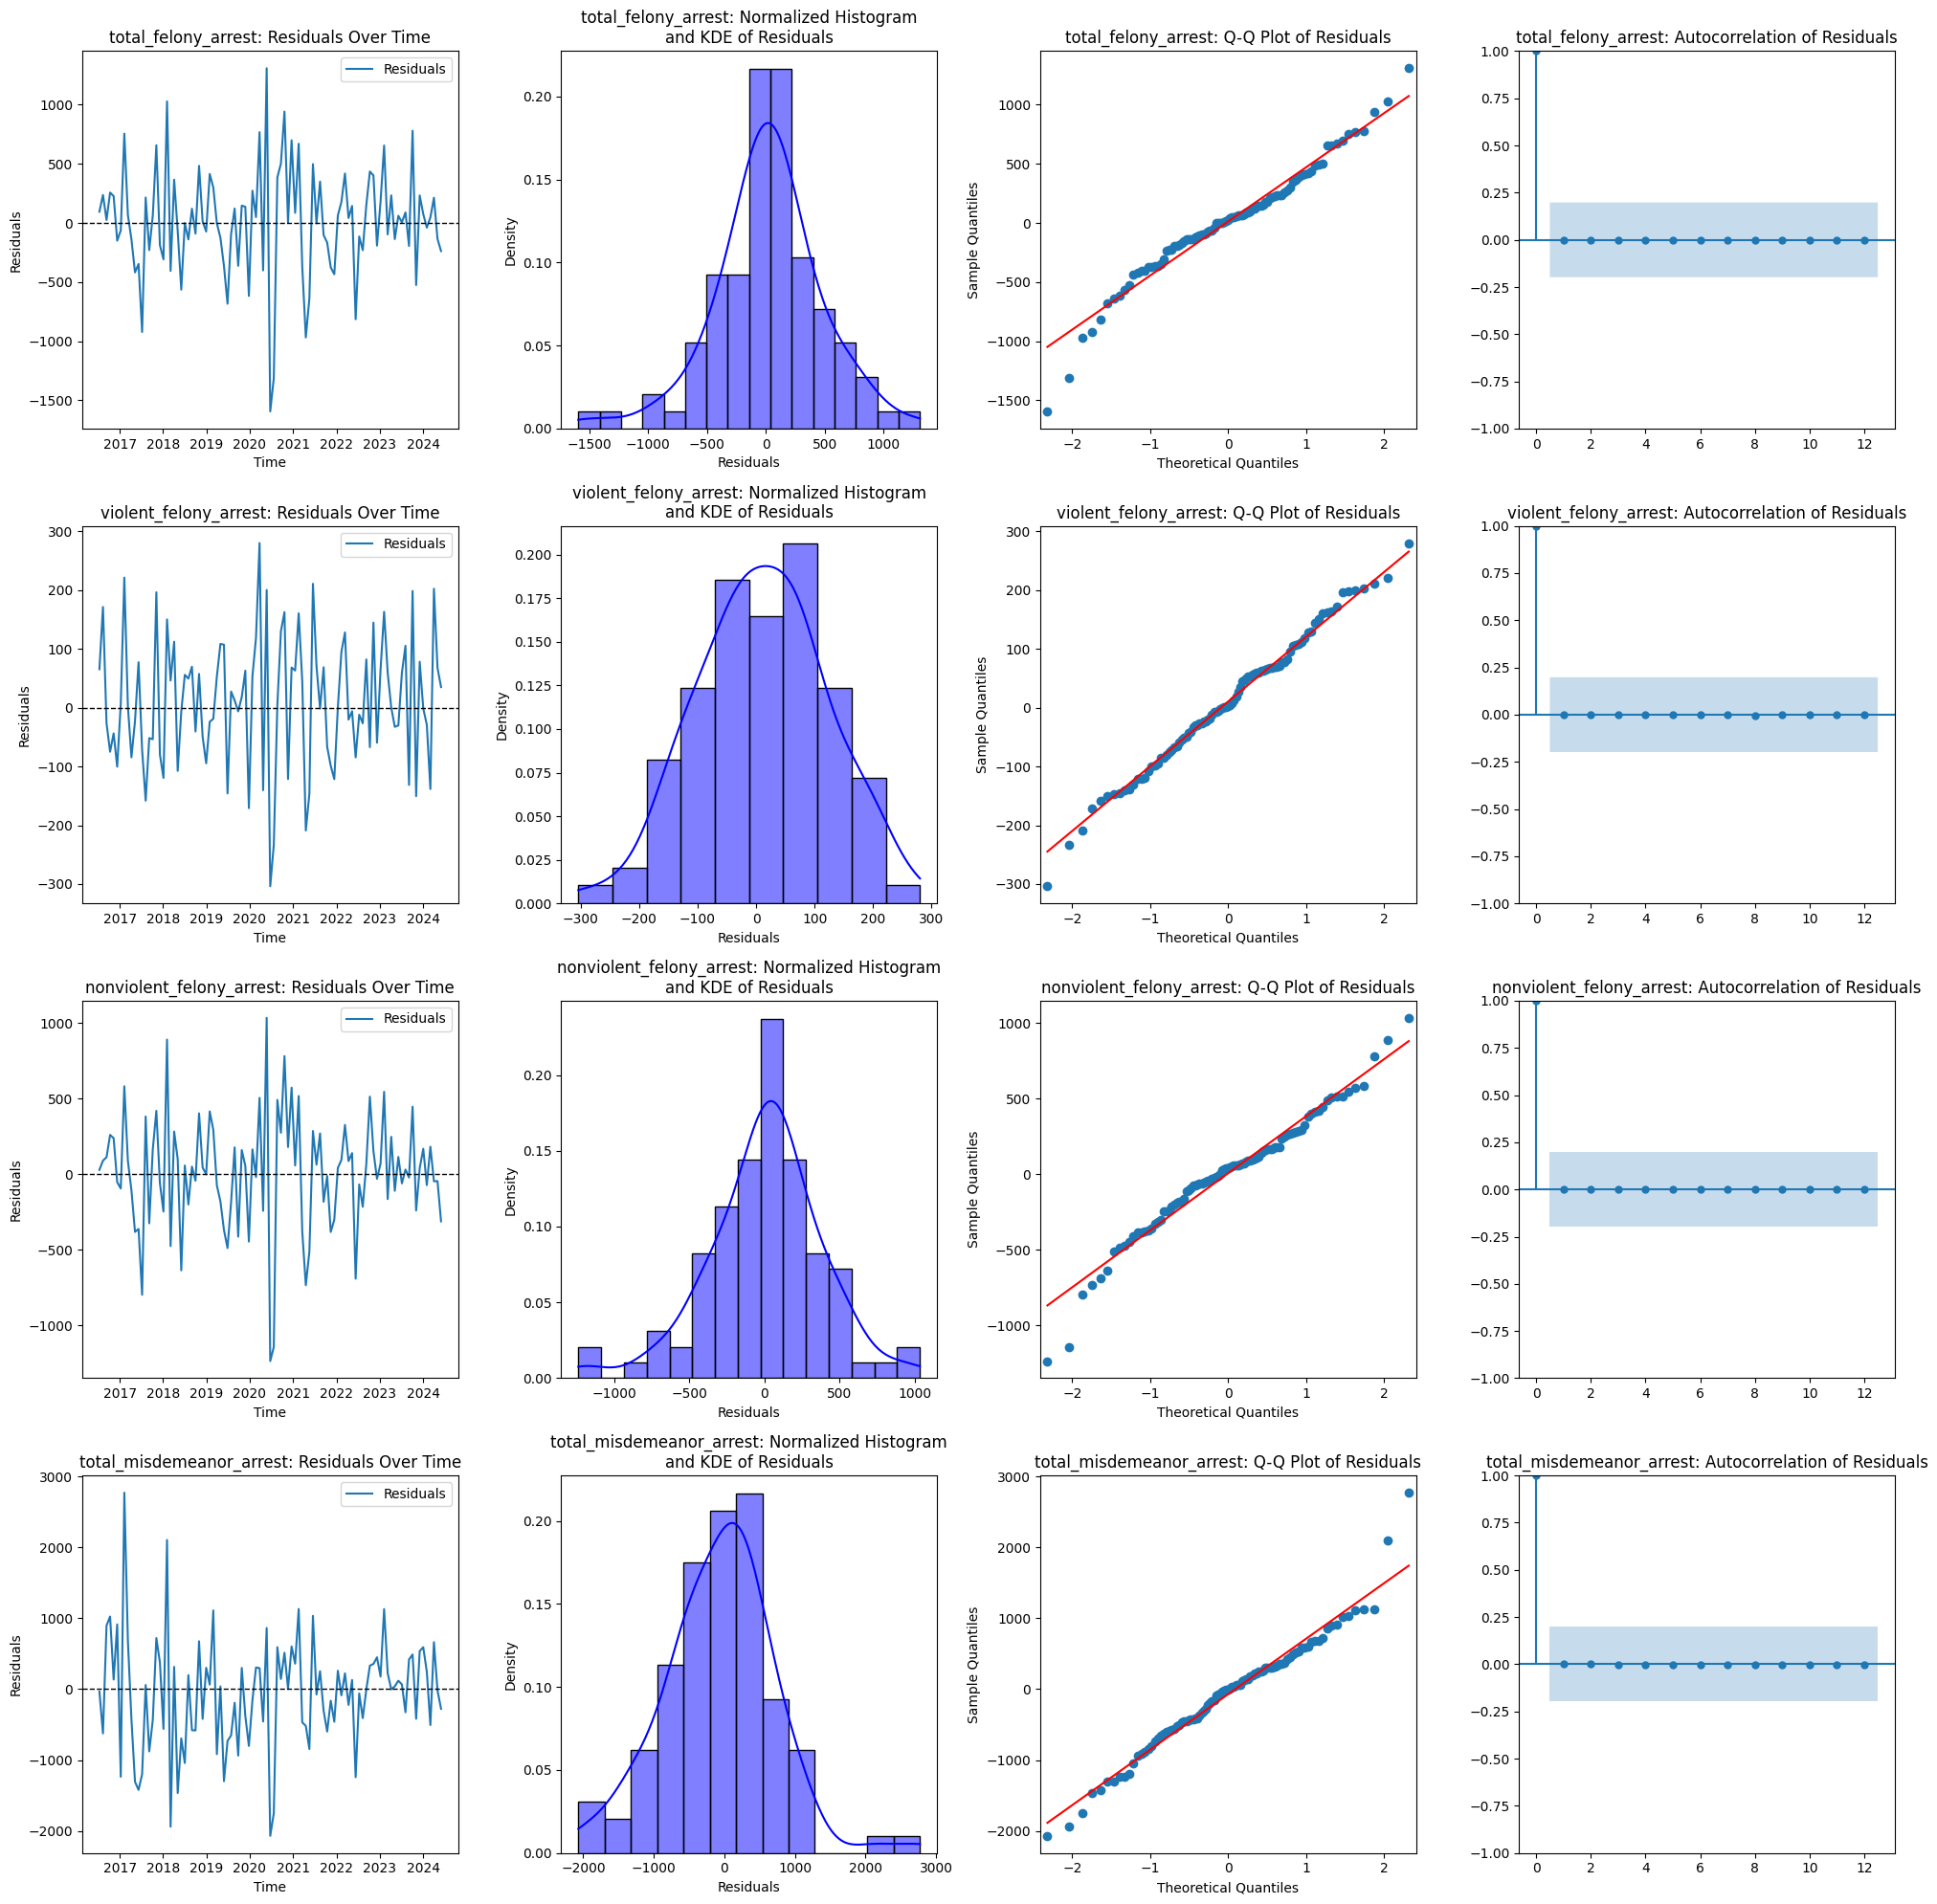

In [27]:
fig, axs = plt.subplots(len(arrest_vars), 4, figsize=(20, 5 * len(arrest_vars)))

    
for i, (arrest_var,crime_var) in enumerate(arrest_vars.items()):
    data = arrest_df[arrest_var].dropna()
    y = log_transform(data)

    exog = log_transform(crime_df[exog_var].dropna())
    # Ensure the exog arrest_variable has the same index as the target arrest_variable
    exog = exog.loc[y.index]

    order = arrest_cv_models[arrest_var]['model params'][0]
    seasonal_order = arrest_cv_models[arrest_var]['model params'][1]

    model = SARIMAX(y, exog = exog, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
        
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    # Calculate residuals
    residuals = arrest_df[arrest_var].dropna() - y_pred

    #plot residual diagnostics
    print(f'Computed the residuals for {arrest_var}')
    # Residuals over time
    axs[i, 0].plot(residuals.index[1:], residuals[1:], label='Residuals')
    axs[i, 0].axhline(0, linestyle='--', color='black', linewidth=1)
    axs[i, 0].set_title(f'{arrest_var}: Residuals Over Time')
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].set_ylabel('Residuals')
    axs[i, 0].legend()
    
    # Histogram and KDE plot of residuals
    sns.histplot(residuals[1:], kde=True,stat='probability', ax=axs[i, 1], color='blue')
    axs[i, 1].set_title(f'{arrest_var}: Normalized Histogram\nand KDE of Residuals')
    axs[i, 1].set_xlabel('Residuals')
    axs[i, 1].set_ylabel('Density')
    
    # Q-Q plot of residuals
    sm.qqplot(residuals[1:], line='s', ax=axs[i, 2])
    axs[i, 2].set_title(f'{arrest_var}: Q-Q Plot of Residuals')
    
    # ACF plot of residuals
    sm.graphics.tsa.plot_acf(residuals, lags=12, ax=axs[i, 3])
    axs[i, 3].set_title(f'{arrest_var}: Autocorrelation of Residuals')
    print(f'Done plotting subplots for {arrest_var}')
# Adjust layout to avoid overlapping
plt.tight_layout()
plt.savefig('../Outputs/arrest_predictions_residual_plots.png', bbox_inches = 'tight')
plt.show()

### Repeat the arrest methods without any exogenous variables

I am curious to see whether including the historical 30-day crime counts in our model is benefitting our models

In [28]:
# Find and evaluate SARIMA models for each arrest variable with NO exogenous crime variables
for arrest_var in arrest_vars.keys():
    y = log_transform(arrest_df[arrest_var].dropna())
    
    best_result, best_params, best_score = grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits)
    
    arrest_cv_models[arrest_var+'_no_exog'] = {'exog' : None, 'result': best_result, 'model params': best_params, 'mae': best_score}
    print(f"Best model for {arrest_var}: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

                                     SARIMAX Results                                      
Dep. Variable:                total_felony_arrest   No. Observations:                   90
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                  68.010
Date:                            Tue, 01 Oct 2024   AIC                           -130.021
Time:                                    13:41:53   BIC                           -122.555
Sample:                                06-13-2016   HQIC                          -127.012
                                     - 10-05-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3642      0.060     -6.070      0.000      -0.482      -0.247
ar.S.L12       0.2196      0.129   

In [29]:
arrest_cv_models

{'total_felony_arrest': {'exog': 'total_felony_crimes',
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d73a1ab610>,
  'model params': ((2, 1, 0), (1, 0, 0, 12)),
  'mae': 428.32630860498494},
 'violent_felony_arrest': {'exog': 'violent_felony_crimes',
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d73a20a710>,
  'model params': ((2, 1, 0), (0, 0, 1, 12)),
  'mae': 122.96759125822646},
 'nonviolent_felony_arrest': {'exog': 'nonviolent_felony_crimes',
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d73a2db510>,
  'model params': ((2, 1, 0), (1, 0, 0, 12)),
  'mae': 389.0927123087114},
 'total_misdemeanor_arrest': {'exog': 'total_misdemeanor_crimes',
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d73a093c50>,
  'model params': ((1, 1, 2), (1, 0, 0, 12)),
  'mae': 689.6917230317464},
 'total_felony_arrest_no_exog': {'exog': None,
  'result': <statsmodels.tsa.statespace.sarimax

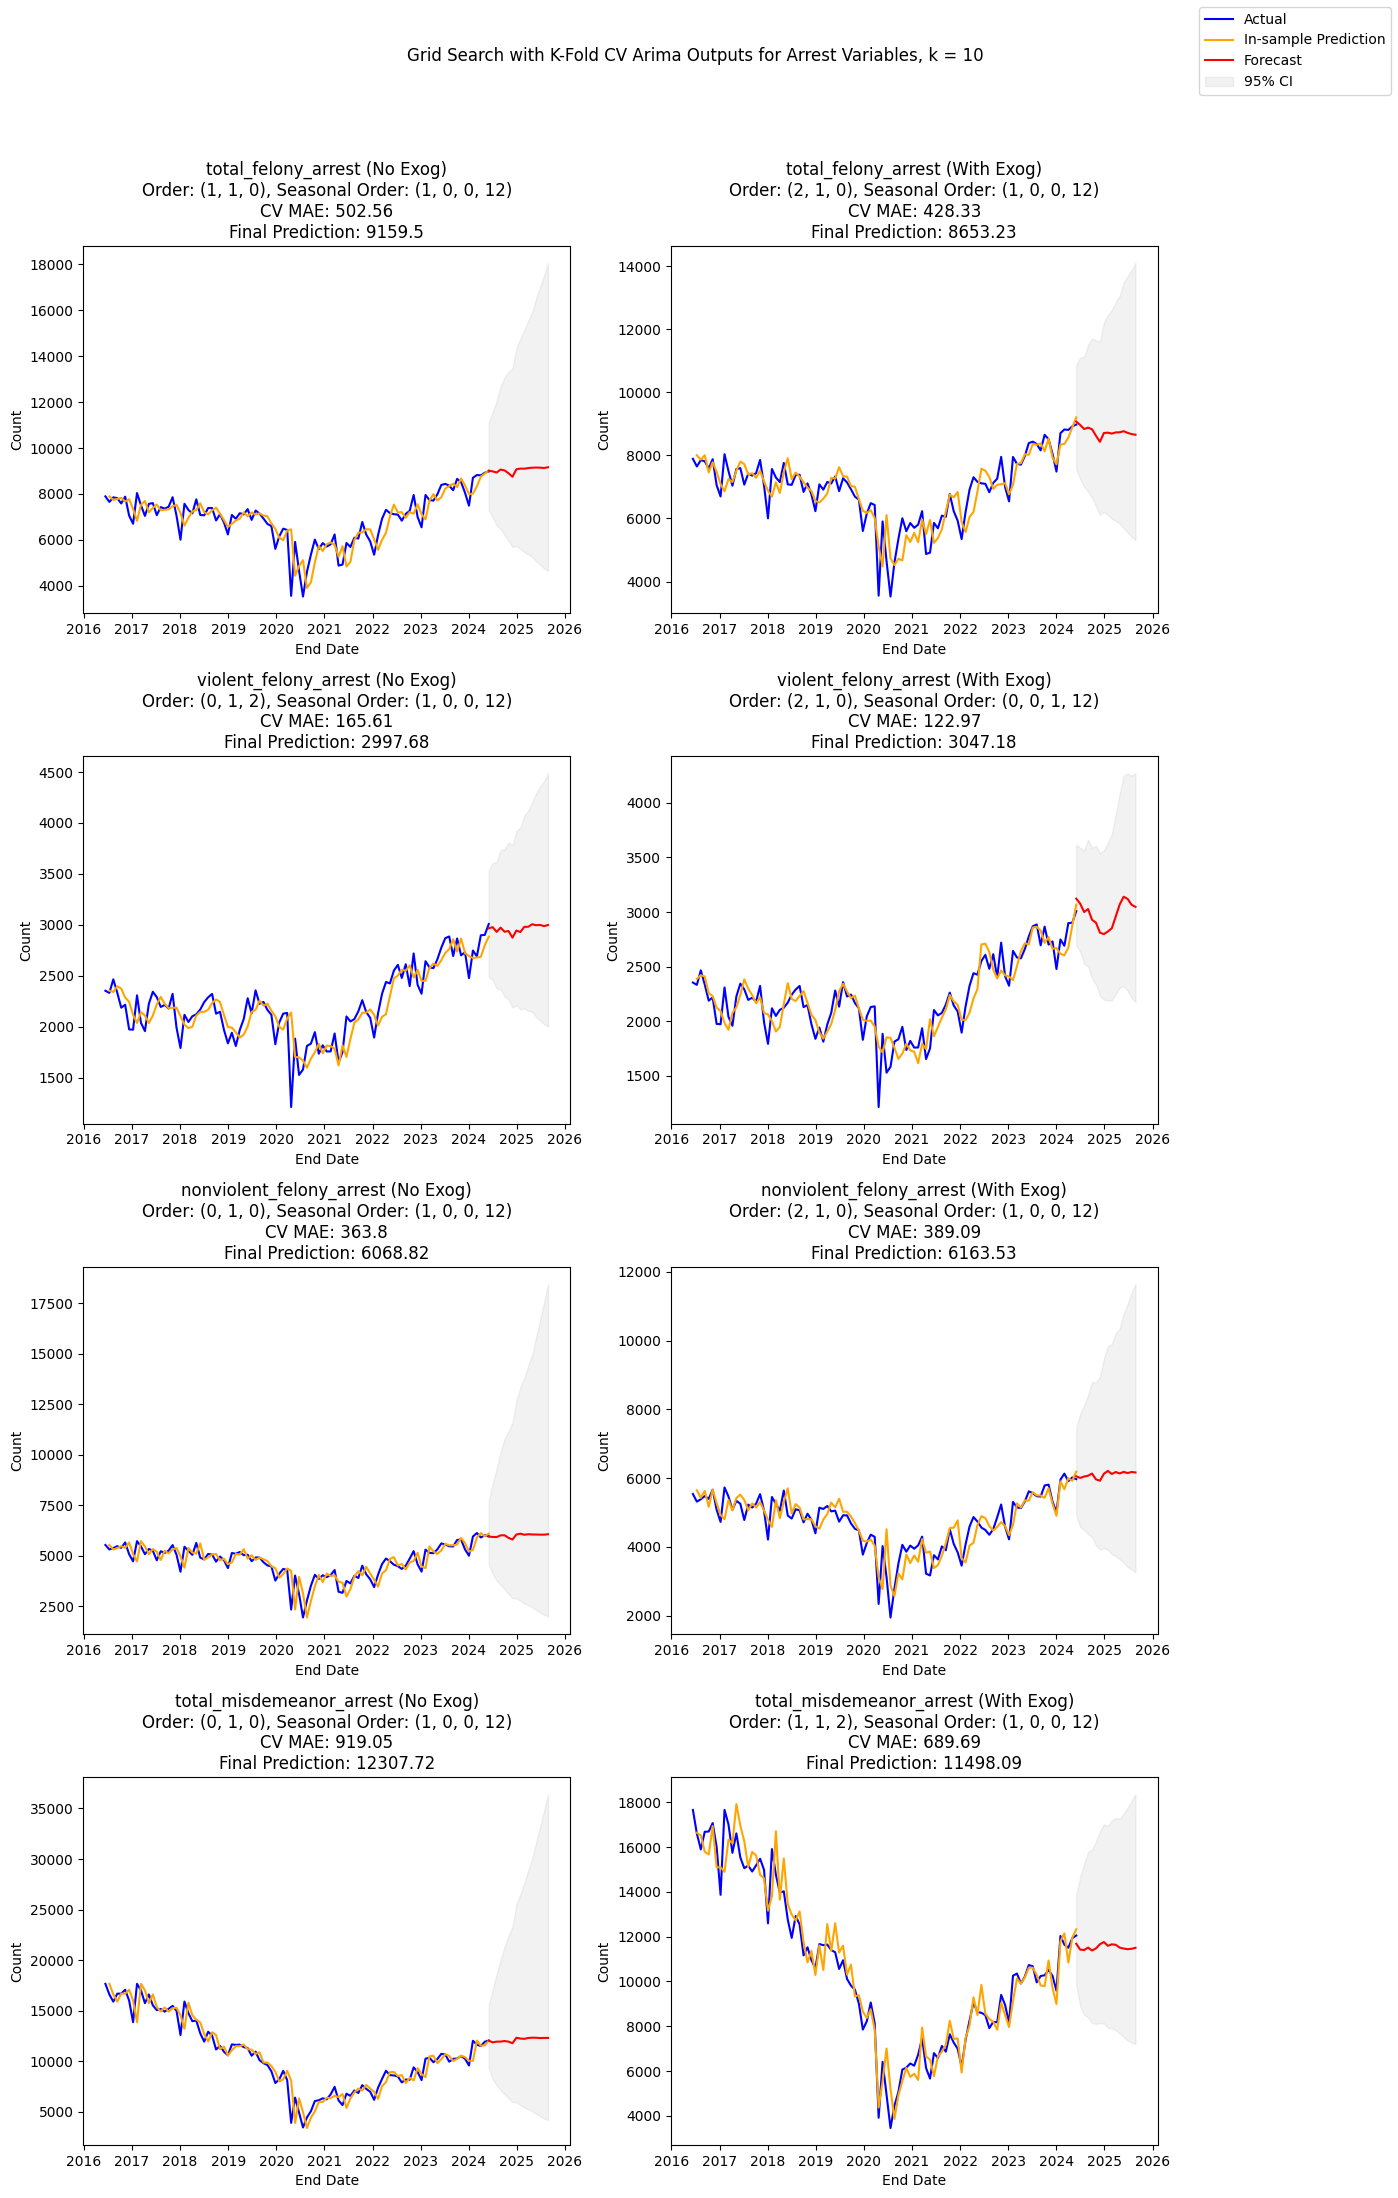

In [30]:
# Define your list of arrest variables

# Set up the subplots (4x2 grid)
fig, axes = plt.subplots(4, 2, figsize=(14, 22))
axes = axes.flatten()

# Iterate over each arrest variable
for i, (arrest_var, exog_var) in enumerate(arrest_vars.items()):
    # Access the models with and without exogenous variables
    model_with_exog = arrest_cv_models[arrest_var]
    model_without_exog = arrest_cv_models[arrest_var + '_no_exog']
    
    # Retrieve data and predictions
    data = arrest_df[arrest_var].dropna()
    y = log_transform(data)
    #exog variable
    exog = log_transform(crime_df[exog_var].dropna())

    # Ensure the exog arrest_variable has the same index as the target arrest_variable
    exog = exog.loc[y.index]

    # Plot without exogenous variables (left column)
    ax_no_exog = axes[i * 2]
    model_no_exog = SARIMAX(y,order=model_without_exog['model params'][0], seasonal_order=model_without_exog['model params'][1])
    results_no_exog = model_no_exog.fit(disp=False)
    predictions_no_exog = results_no_exog.predict(start=y.index[0], end=y.index[-1])
    y_pred_no_exog = inverse_log_transform(predictions_no_exog)
    #get forecast
    forecast_no_exog = results_no_exog.get_forecast(steps=n_steps_arr).predicted_mean
    conf_int_no_exog = results_no_exog.get_forecast(steps=n_steps_arr).conf_int()
    #save to dictionary
    arrest_cv_models[arrest_var + '_no_exog']['predictions'] = inverse_log_transform(forecast_no_exog.values)
    
    # Back-transform confidence intervals
    lower_bound_no_exog = inverse_log_transform(conf_int_no_exog.iloc[:, 0])
    upper_bound_no_exog = inverse_log_transform(conf_int_no_exog.iloc[:, 1])

    ax_no_exog.plot(data.index, data, label='Actual', color='blue')
    ax_no_exog.plot(data.index[1:], y_pred_no_exog[1:], label='In-sample Prediction', color='orange')
    ax_no_exog.plot(pd.date_range(start=data.index[-1], periods=n_steps_arr, freq='30D'), inverse_log_transform(forecast_no_exog), label='Forecast', color='red')
    ax_no_exog.fill_between(pd.date_range(start=data.index[-1], periods=n_steps_arr, freq='30D'), lower_bound_no_exog, upper_bound_no_exog, color='grey', alpha=0.1, label='95% CI')
    ax_no_exog.set_title(f"{arrest_var} (No Exog)\nOrder: {model_without_exog['model params'][0]}, Seasonal Order: {model_without_exog['model params'][1]}\nCV MAE: {round(model_without_exog['mae'], 2)}\nFinal Prediction: {round(inverse_log_transform(forecast_no_exog)[-1],2)}")
    ax_no_exog.set_xlabel('End Date')
    ax_no_exog.set_ylabel('Count')

    # Plot with exogenous variables (right column)
    ax_with_exog = axes[i * 2 + 1]
    model = SARIMAX(y,exog = exog, order=model_with_exog['model params'][0], seasonal_order=model_with_exog['model params'][1])
    results = model.fit(disp=False)
    predictions_with_exog = results.predict(start=y.index[0], end=y.index[-1], exog=log_transform(crime_df[exog_var].dropna()))
    y_pred_with_exog = inverse_log_transform(predictions_with_exog)
    #forecast
    forecast_with_exog = results.get_forecast(steps=n_steps_arr, exog=log_transform(crime_cv_results[exog_var]['predictions'])).predicted_mean
    conf_int_with_exog = results.get_forecast(steps=n_steps_arr, exog=log_transform(crime_cv_results[exog_var]['predictions'])).conf_int()
    #save to dictionary
    arrest_cv_models[arrest_var]['predictions'] = inverse_log_transform(forecast_with_exog.values)
    
    # Back-transform confidence intervals
    lower_bound_with_exog = inverse_log_transform(conf_int_with_exog.iloc[:, 0])
    upper_bound_with_exog = inverse_log_transform(conf_int_with_exog.iloc[:, 1])

    ax_with_exog.plot(data.index, data, label='Actual', color='blue')
    ax_with_exog.plot(data.index[1:], y_pred_with_exog[1:], label='In-sample Prediction', color='orange')
    ax_with_exog.plot(pd.date_range(start=data.index[-1], periods=n_steps_arr, freq='30D'), inverse_log_transform(forecast_with_exog), label='Forecast', color='red')
    ax_with_exog.fill_between(pd.date_range(start=data.index[-1], periods=n_steps_arr, freq='30D'), lower_bound_with_exog, upper_bound_with_exog, color='grey', alpha=0.1, label='95% CI')
    ax_with_exog.set_title(f"{arrest_var} (With Exog)\nOrder: {model_with_exog['model params'][0]}, Seasonal Order: {model_with_exog['model params'][1]}\nCV MAE: {round(model_with_exog['mae'], 2)}\nFinal Prediction: {round(inverse_log_transform(forecast_with_exog)[-1],2)}")
    ax_with_exog.set_xlabel('End Date')
    ax_with_exog.set_ylabel('Count')

# Create a single legend
handles, labels = ax_with_exog.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle(f"Grid Search with K-Fold CV Arima Outputs for Arrest Variables, k = {n_splits}")

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, .95])  # Leave space on the right for the legend
plt.savefig("../Outputs/grid_search_kfold_cv_arrest_predictions_with_without_exog.png", bbox_inches = 'tight')
plt.show()

Since all the exogenous variables are statistically significant in predicting the arrest counts, we will keep these models as opposed to the models without exogenous variables.

# Next Step: Finding the optimal model for DOC admission counts

We want to find the optimal ARIMA parameters and the optimal combination of exogenous variables.

In [31]:
#list of exog combos to test
adm_model_exog = [None,
                  ['total_felony_arrest','total_misdemeanor_arrest'],
                  ['total_misdemeanor_arrest','violent_felony_arrest','nonviolent_felony_arrest'],
                  ['violent_felony_arrest','nonviolent_felony_arrest'],
                  'violent_felony_arrest']

# Find and evaluate SARIMA models for each arrest variable with exogenous crime variables
adm_cv_models = {}
y = log_transform(joined_df['admission_count'].dropna())
    
for i,model_vars in enumerate(adm_model_exog):
    exog = joined_df[model_vars].dropna() if model_vars is not None else None
    
    # Ensure the exog variable has the same index as the target variable
    if model_vars is not None:
        # Ensure exog is a DataFrame even if only one variable is selected
        if isinstance(exog, pd.Series):
            exog = exog.to_frame()

        # See how many points we may need to add to the exog signal
        diff_n = len(y) - len(exog)
        missing_data = pd.DataFrame(columns=exog.columns)
        for var in exog.columns:
            missing_data[var] = arrest_cv_models[var]['predictions'][0:diff_n]
        exog = pd.concat([exog, missing_data], ignore_index=True)

        # Ensure the exog variable has the same index as the target variable
        exog = log_transform(exog.loc[y.index])
        
    best_result, best_params, best_score = grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits, exog=exog)
    
    adm_cv_models[f'model_{i}'] = {'exog_vars': model_vars,'result': best_result, 'model params': best_params, 'mae': best_score}
    print(f"Best model for {model_vars}: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

                                      SARIMAX Results                                       
Dep. Variable:                      admission_count   No. Observations:                   92
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                  34.982
Date:                              Tue, 01 Oct 2024   AIC                            -63.963
Time:                                      14:10:26   BIC                            -56.431
Sample:                                           0   HQIC                           -60.925
                                               - 92                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.1827      1.846     -0.099      0.921      -3.801       3.436
ma.S.L12       0.33

In [32]:
adm_cv_models

{'model_0': {'exog_vars': None,
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d73a195e90>,
  'model params': ((0, 1, 0), (1, 0, 1, 12)),
  'mae': 231.32165310795995},
 'model_1': {'exog_vars': ['total_felony_arrest', 'total_misdemeanor_arrest'],
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d73942e850>,
  'model params': ((0, 1, 3), (0, 0, 0, 12)),
  'mae': 165.6067065987699},
 'model_2': {'exog_vars': ['total_misdemeanor_arrest',
   'violent_felony_arrest',
   'nonviolent_felony_arrest'],
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d73e21e990>,
  'model params': ((0, 1, 3), (0, 0, 0, 12)),
  'mae': 162.44521138544087},
 'model_3': {'exog_vars': ['violent_felony_arrest',
   'nonviolent_felony_arrest'],
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d73956d750>,
  'model params': ((0, 1, 3), (0, 0, 0, 12)),
  'mae': 190.41355182276476},
 'model_4': {'exog_vars': 'viol

Computed the residuals for admission count model with exogenous variables: None
Done plotting subplots for None
Computed the residuals for admission count model with exogenous variables: ['total_felony_arrest', 'total_misdemeanor_arrest']
Done plotting subplots for ['total_felony_arrest', 'total_misdemeanor_arrest']
Computed the residuals for admission count model with exogenous variables: ['total_misdemeanor_arrest', 'violent_felony_arrest', 'nonviolent_felony_arrest']
Done plotting subplots for ['total_misdemeanor_arrest', 'violent_felony_arrest', 'nonviolent_felony_arrest']
Computed the residuals for admission count model with exogenous variables: ['violent_felony_arrest', 'nonviolent_felony_arrest']
Done plotting subplots for ['violent_felony_arrest', 'nonviolent_felony_arrest']
Computed the residuals for admission count model with exogenous variables: violent_felony_arrest
Done plotting subplots for violent_felony_arrest


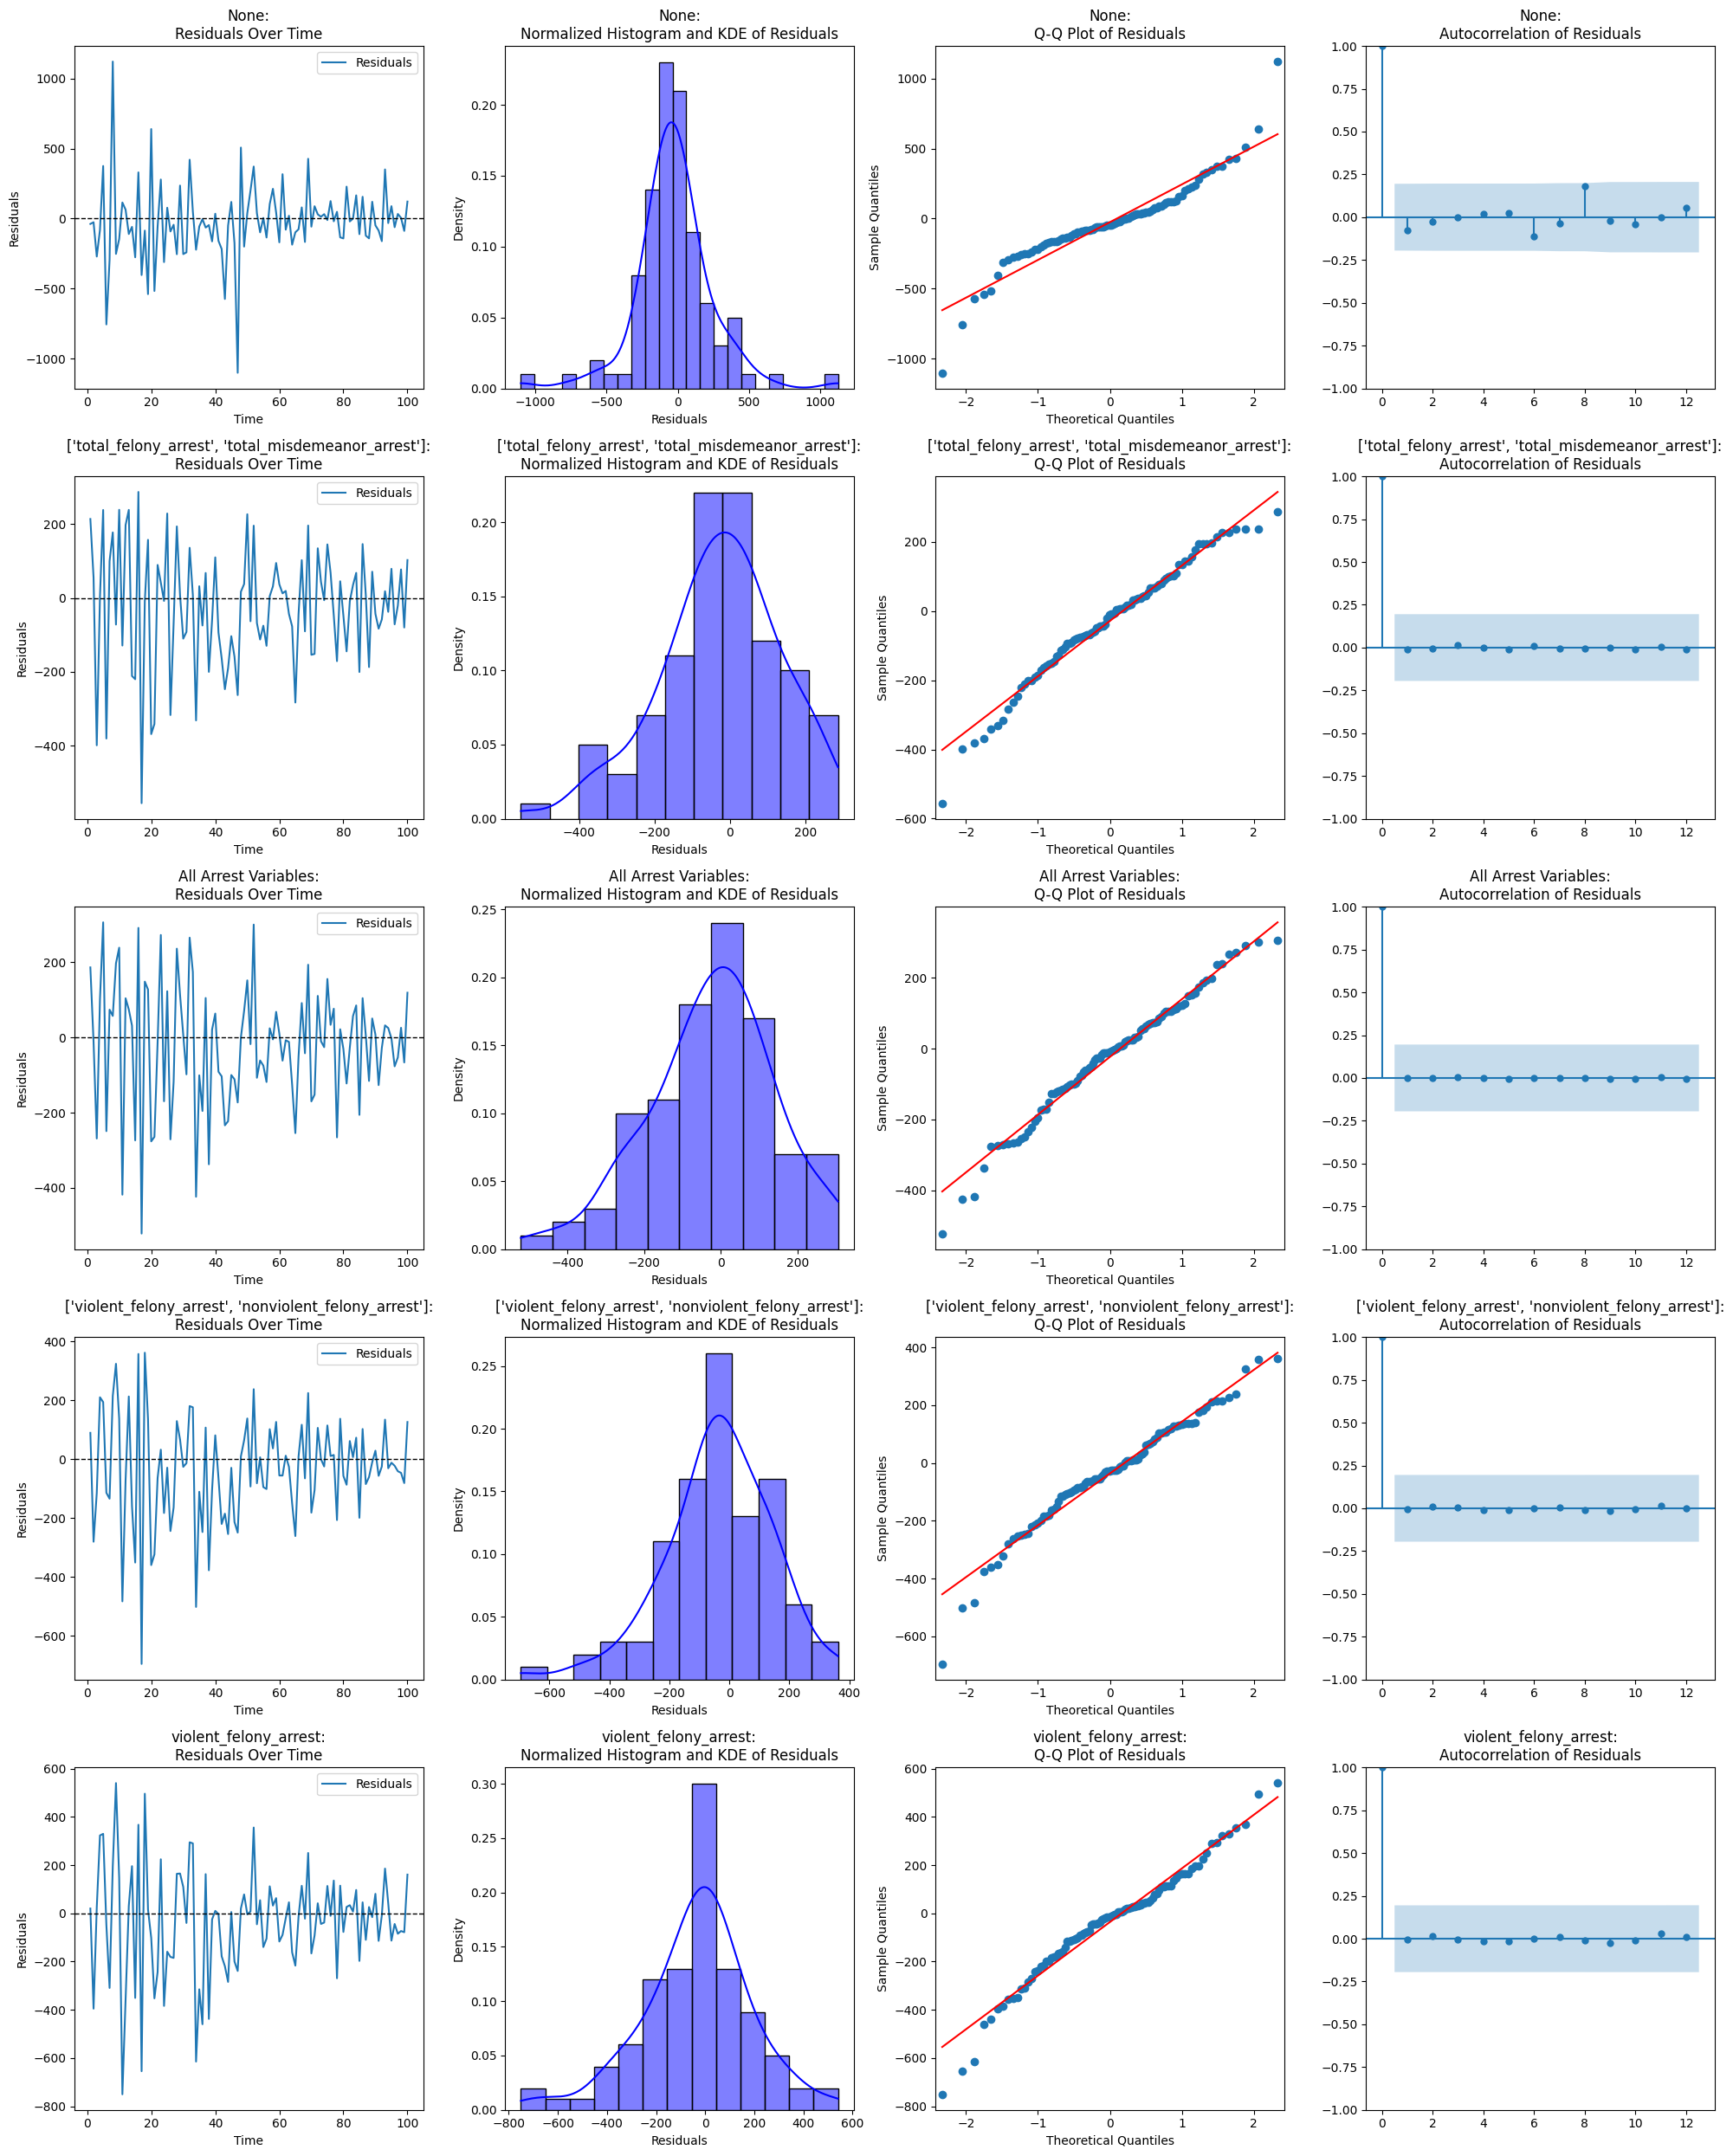

In [33]:
#plot the residual diagnostics
fig, axs = plt.subplots(len(adm_model_exog), 4, figsize=(20, 5 * len(adm_model_exog)))

y = log_transform(joined_df['admission_count'].dropna())
    
for i,model_vars in enumerate(adm_model_exog):
    exog = joined_df[model_vars].dropna() if model_vars is not None else None
    
    if model_vars is not None:
        # Ensure exog is a DataFrame even if only one variable is selected
        if isinstance(exog, pd.Series):
            exog = exog.to_frame()

        # See how many points we may need to add to the exog signal
        diff_n = len(y) - len(exog)
        missing_data = pd.DataFrame(columns=exog.columns)
        for var in exog.columns:
            missing_data[var] = arrest_cv_models[var]['predictions'][0:diff_n]
        exog = pd.concat([exog, missing_data], ignore_index=True)

        # Ensure the exog variable has the same index as the target variable
        exog = log_transform(exog.loc[y.index])   

    order = adm_cv_models[f'model_{i}']['model params'][0]
    seasonal_order = adm_cv_models[f'model_{i}']['model params'][1]

    model = SARIMAX(y, exog = exog, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
        
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    # Calculate residuals
    residuals = joined_df['admission_count'].dropna() - y_pred

    #plot residual diagnostics
    print(f'Computed the residuals for admission count model with exogenous variables: {model_vars}')
    # Residuals over time
    title_var = model_vars if model_vars != ['total_misdemeanor_arrest', 'violent_felony_arrest', 'nonviolent_felony_arrest'] else 'All Arrest Variables'
    axs[i, 0].plot(residuals.index[1:], residuals[1:], label='Residuals')
    axs[i, 0].axhline(0, linestyle='--', color='black', linewidth=1)
    axs[i, 0].set_title(f'{title_var}:\nResiduals Over Time')
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].set_ylabel('Residuals')
    axs[i, 0].legend()
    
    # Histogram and KDE plot of residuals
    sns.histplot(residuals[1:], kde=True,stat='probability', ax=axs[i, 1], color='blue')
    axs[i, 1].set_title(f'{title_var}:\nNormalized Histogram and KDE of Residuals')
    axs[i, 1].set_xlabel('Residuals')
    axs[i, 1].set_ylabel('Density')
    
    # Q-Q plot of residuals
    sm.qqplot(residuals[1:], line='s', ax=axs[i, 2])
    axs[i, 2].set_title(f'{title_var}:\nQ-Q Plot of Residuals')
    
    # ACF plot of residuals
    sm.graphics.tsa.plot_acf(residuals, lags=12, ax=axs[i, 3])
    axs[i, 3].set_title(f'{title_var}:\nAutocorrelation of Residuals')
    print(f'Done plotting subplots for {model_vars}')
# Adjust layout to avoid overlapping
plt.tight_layout()
plt.savefig('../Outputs/adm_predictions_residual_plots.png', bbox_inches = 'tight')
plt.show()

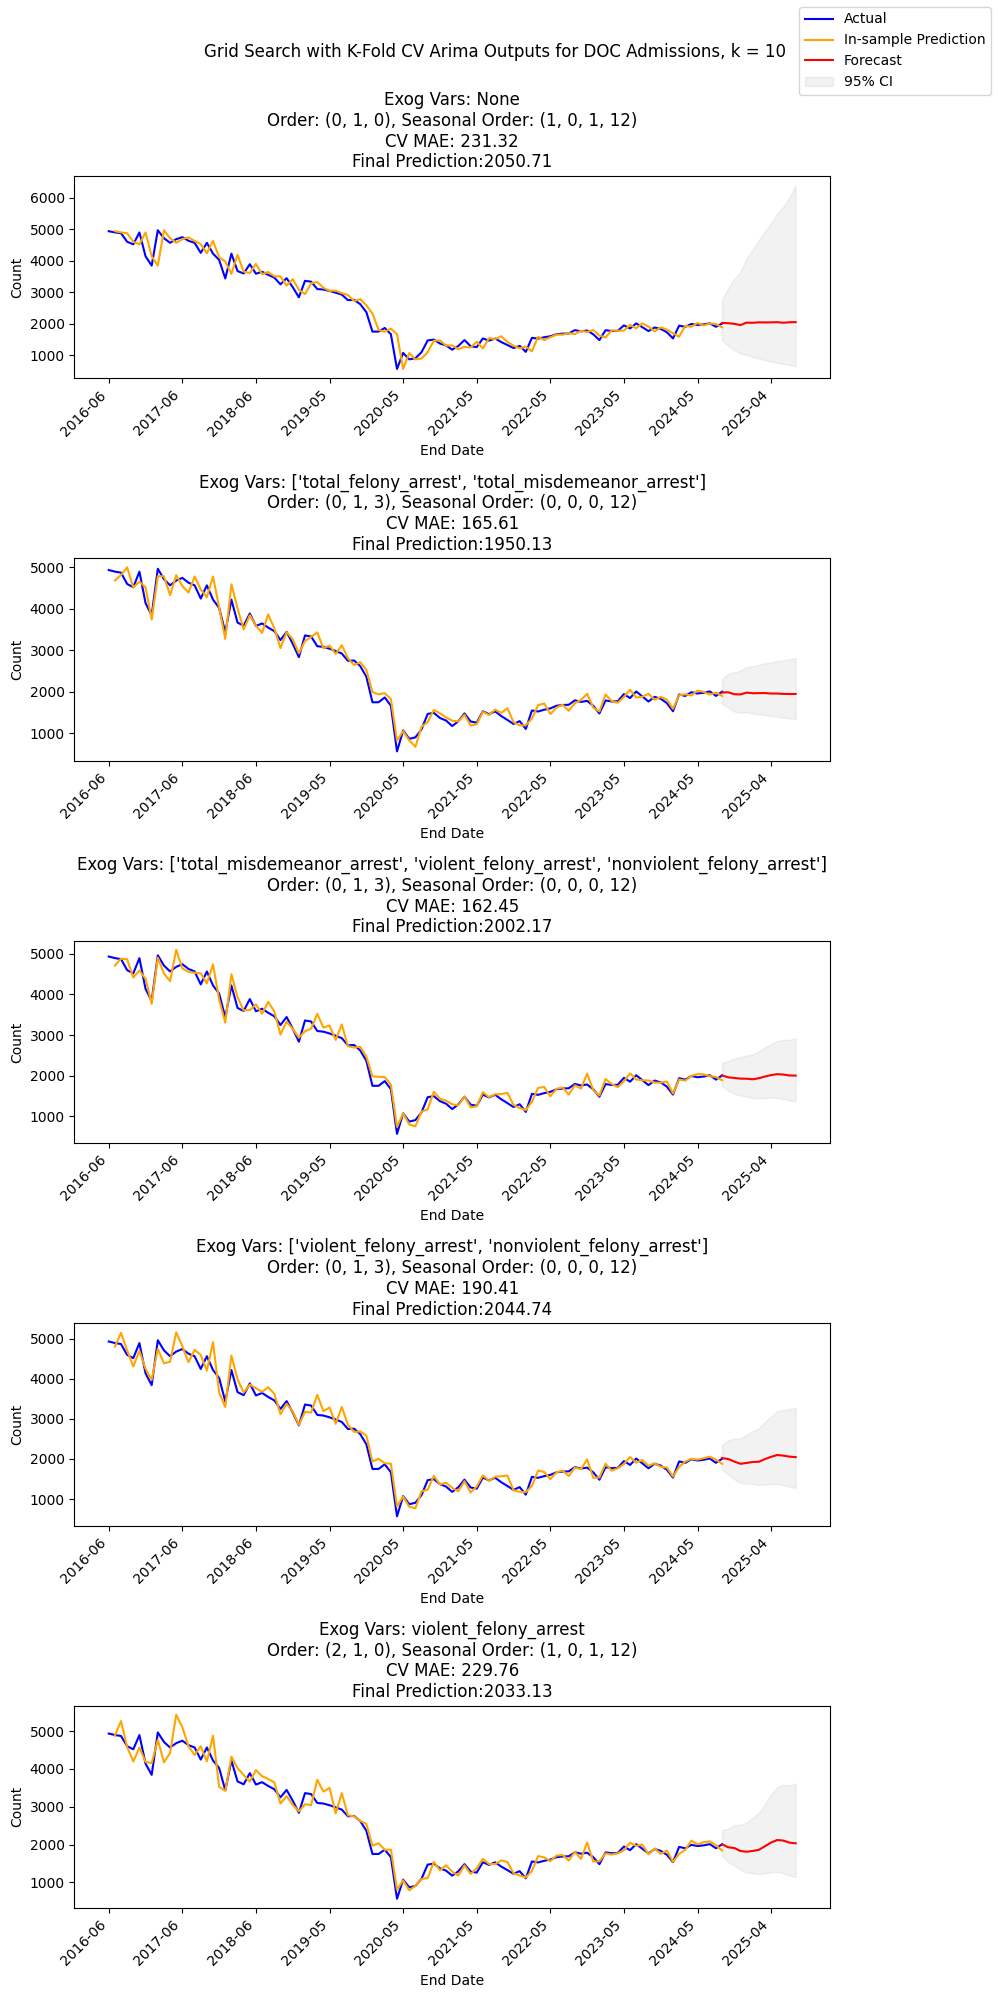

In [34]:
# Set up the subplots
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
axes = axes.flatten()

data = joined_df[['End Date','admission_count']].dropna()
y = log_transform(data['admission_count'])

for i,model_vars in enumerate(adm_model_exog):
    ax = axes[i]

    exog = joined_df[model_vars].dropna() if model_vars is not None else None
    
    if model_vars is not None:
        # Ensure exog is a DataFrame even if only one variable is selected
        if isinstance(exog, pd.Series):
            exog = exog.to_frame()
            
        # See how many points we may need to add to the exog signal
        diff_n = len(y) - len(exog)
        missing_data = pd.DataFrame(columns=exog.columns)
        future_exog = pd.DataFrame(columns = exog.columns, index = np.arange(len(exog),len(exog)+n_steps_adm))
    
        for var in exog.columns:
            missing_data[var] = arrest_cv_models[var]['predictions'][0:diff_n]
            future_exog[var] = arrest_cv_models[var]['predictions'][diff_n:]
        exog = pd.concat([exog, missing_data], ignore_index=True)
        # Ensure the exog variable has the same index as the target variable
        exog = log_transform(exog.loc[y.index])   
        future_exog = log_transform(future_exog)
    else: 
        future_exog = None

        
    order = adm_cv_models[f'model_{i}']['model params'][0]
    seasonal_order = adm_cv_models[f'model_{i}']['model params'][1]
    cv_mae = adm_cv_models[f'model_{i}']['mae']
    
    model = SARIMAX(y, exog = exog, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    #in sample
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    #predictions
    forecast_log = results.get_forecast(steps=n_steps_adm, exog=future_exog)
    forecast_mean_log = forecast_log.predicted_mean
    conf_int_log = forecast_log.conf_int()

    # Bias-adjusted mean forecast back-transformation
    forecast = inverse_log_transform(forecast_mean_log)
    adm_cv_models[f'model_{i}']['prediction'] = forecast.values
    # Back-transform confidence intervals
    lower_bound = inverse_log_transform(conf_int_log.iloc[:, 0])
    upper_bound = inverse_log_transform(conf_int_log.iloc[:, 1])

    IS_mae = mean_absolute_error(data['admission_count'].iloc[1:],y_pred.iloc[1:])

    # Plot the actual data
    ax.plot(data['End Date'], data['admission_count'], label='Actual', color='blue')

    # Plot the in-sample prediction
    ax.plot(data['End Date'].iloc[1:], y_pred[1:], label='In-sample Prediction', color='orange')

    # Plot the forecast
    future_dates = pd.date_range(start=data['End Date'].iloc[-1], periods=n_steps_adm, freq='30D')
    ax.plot(future_dates, forecast, label='Forecast', color='red')

    # Plot the confidence intervals
    ax.fill_between(future_dates, lower_bound, upper_bound, color='grey', alpha=0.1, label='95% CI')
    
    # Set title and labels, including model parameters
    title = f"Exog Vars: {model_vars}\nOrder: {order}, Seasonal Order: {seasonal_order}\nCV MAE: {round(cv_mae,2)}\nFinal Prediction:{round(forecast.values[-1],2)}"
    ax.set_title(title)
    ax.set_xlabel('End Date')
    ax.set_ylabel('Count')

    # Set x-ticks and rotate labels
    dates = pd.date_range(start=data['End Date'].iloc[0], periods=len(data)+n_steps_adm, freq='30D')

    ax.set_xticks(dates[::12])
    ax.set_xticklabels(dates[::12].strftime('%Y-%m'), rotation=45, ha='right')

# Create a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle(f"Grid Search with K-Fold CV Arima Outputs for DOC Admissions, k = {n_splits}")

# Adjust layout
plt.tight_layout(rect=[0, 0, .85, .98])  # Leave space on the right for the legend
plt.savefig("../Outputs/grid_search_kfold_cv_adm_predictions.png", bbox_inches = 'tight')
plt.show()

Based on the finds above, the model that minimizes the out of sample MAE for predicting 30 day jail admission counts is the model that includes violent and nonviolent felony arrests only. Followed closely by the model that uses no exogenous variables.

# Predicting Jail Population

We are going to repeat the methods in the above section but for 30-day average daily jail population (ADP). We will conduct a grid search rolling window cross validation technique to find the optimal SARIMA parameters based on minimal out of sample mean absolute error. We will also iterate through a combination of exogenous variables to see which, in combination with the SARIMA parameters, are the optimal model. My idea for the combinations of exogenous variables are as follows:

1. None

2. admission counts (with prediction values from no exog vars and a combination of arrest variables)

3. arrest counts (with and without exogenous crime variables)

In [35]:
y = joined_df[['End Date','ADP']].dropna()
y.set_index('End Date', inplace=True)
y = log_transform(y)

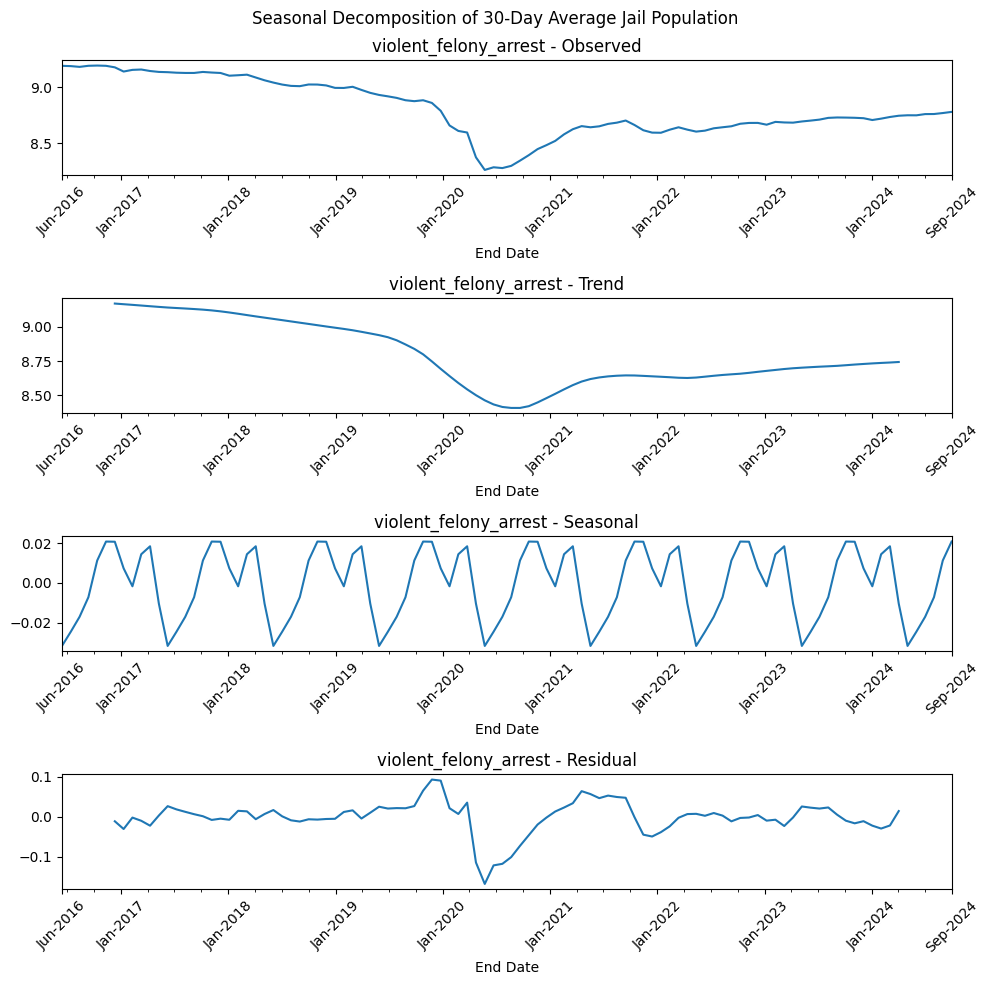

In [36]:
#first lets seasonal decompose
fig, axes = plt.subplots(4,1, figsize=(10, 10))

# Perform seasonal decomposition
result = seasonal_decompose(y, model='additive', period=12)  # Adjust 'period' according to your data
    
# Plot each component in a separate subplot
result.observed.plot(ax=axes[0], legend=False, title=f'{var} - Observed')
result.trend.plot(ax=axes[1], legend=False, title=f'{var} - Trend')
result.seasonal.plot(ax=axes[2], legend=False, title=f'{var} - Seasonal')
result.resid.plot(ax=axes[3], legend=False, title=f'{var} - Residual')

for j in range(4):
    axes[j].set_xlabel('End Date')
    axes[j].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b-%Y'))
    axes[j].tick_params(axis='x', rotation=45)

# Adjust layout
plt.suptitle('Seasonal Decomposition of 30-Day Average Jail Population')
plt.tight_layout()
plt.show()

In [37]:
#check d value of the signal
d = ndiffs(y, test='adf')
print(d)

2


In [38]:
#print adf test stats
from statsmodels.tsa.stattools import adfuller

result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

result = adfuller(y.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

result = adfuller(y.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.742396
p-value: 0.409411
Critical Values:
	1%: -3.501
	5%: -2.892
	10%: -2.583
ADF Statistic: -3.789485
p-value: 0.003017
Critical Values:
	1%: -3.501
	5%: -2.892
	10%: -2.583
ADF Statistic: -13.302303
p-value: 0.000000
Critical Values:
	1%: -3.499
	5%: -2.892
	10%: -2.583


In [39]:
adp_cv_results = {}
y = log_transform(joined_df['ADP'].dropna())
#first lets grid search with no exog vars    
best_result, best_params, best_score = grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits)

adp_cv_results[f'model_0'] = {'exog_vars': None,'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with no Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   93
Model:               SARIMAX(1, 2, 2)   Log Likelihood                 190.147
Date:                Tue, 01 Oct 2024   AIC                           -372.295
Time:                        15:02:02   BIC                           -362.251
Sample:                             0   HQIC                          -368.243
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2643      0.135     -1.957      0.050      -0.529       0.000
ma.L1          0.0630      0.143      0.440      0.660      -0.217       0.343
ma.L2         -0.6109      0.079     -7.730      0.0

By default, the grid_search_sarimax function uses d=2. However I also want to use d = 1 with no exogenous variables to compare outputs.

In [40]:
#redefine the function to allow for d and D inputs
def grid_search_sarimax_v2(y, p_values, q_values, P_values, Q_values, s, n_splits, exog=None, d=None, D=None):
    best_score, best_params = float("inf"), None
    
    # If d or D are not provided, use ndiffs and nsdiffs to determine them
    d_value = d if d is not None else ndiffs(y.dropna(), test='adf')
    D_value = D if D is not None else nsdiffs(y.dropna(), m=s)
    
    pdq = list(itertools.product(p_values, [d_value], q_values))
    seasonal_pdq = list(itertools.product(P_values, [D_value], Q_values, [s]))
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                results, mae_score = time_series_cv(y, order=param, seasonal_order=param_seasonal, n_splits=n_splits, exog=exog)
                if mae_score < best_score:
                    best_score, best_params = mae_score, (param, param_seasonal)
                    best_result = results
            except Exception as e:
                continue
                
    print(best_result.summary())
    return best_result, best_params, best_score

In [41]:
#first lets grid search with no exog vars    
#change p values for ARIMA model to start at 1 for d=1 bc the signal with be under differenced
p_values_d1 = range(1, 4)

best_result, best_params, best_score = grid_search_sarimax_v2(y, p_values_d1, q_values, P_values, Q_values, s, n_splits, d = 1)

adp_cv_results[f'model_1'] = {'exog_vars': None,'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with no Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

                                      SARIMAX Results                                      
Dep. Variable:                                 ADP   No. Observations:                   93
Model:             SARIMAX(2, 1, 1)x(1, 0, [], 12)   Log Likelihood                 194.611
Date:                             Tue, 01 Oct 2024   AIC                           -379.223
Time:                                     15:08:54   BIC                           -366.614
Sample:                                          0   HQIC                          -374.133
                                              - 93                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0818      0.193     -0.424      0.671      -0.460       0.296
ar.L2          0.1569      

Now let's do the other models both with d=2 and d=1

In [42]:
adp_cv_results

{'model_0': {'exog_vars': None,
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d7398edcd0>,
  'model params': ((1, 2, 2), (0, 0, 0, 12)),
  'mae': 445.99001989961255},
 'model_1': {'exog_vars': None,
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d73cd5cc90>,
  'model params': ((2, 1, 1), (1, 0, 0, 12)),
  'mae': 407.8817335761099}}

In [43]:
#first do admission exog with predictions from no other exog vars
exog_vars = 'admission_count'
exog = joined_df[exog_vars].dropna()
#fill missing values 
missing_data_1 = pd.Series(data = adm_cv_models[f'model_0']['prediction'][0:diff_n],
                            index=np.arange(len(exog),len(exog)+diff_n))
exog_1 = pd.concat([exog, missing_data_1], ignore_index=True)
# Ensure the exog variable has the same index as the target variable
exog_1 = log_transform(exog_1.loc[y.index]) 
best_result, best_params, best_score = grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits, exog = exog_1)

adp_cv_results[f'model_2'] = {'exog_vars': exog_vars,'exog_signal':exog_1,'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with admission count as an Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

best_result, best_params, best_score = grid_search_sarimax_v2(y, p_values_d1, q_values, P_values, Q_values, s, n_splits, exog = exog_1, d = 1)

adp_cv_results[f'model_3'] = {'exog_vars': exog_vars,'exog_signal':exog_1,'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with admission count as an Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   93
Model:               SARIMAX(1, 2, 2)   Log Likelihood                 196.255
Date:                Tue, 01 Oct 2024   AIC                           -382.510
Time:                        15:16:01   BIC                           -369.956
Sample:                             0   HQIC                          -377.445
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0324      0.010      3.329      0.001       0.013       0.051
ar.L1         -0.2320      0.248     -0.936      0.349      -0.718       0.254
ma.L1          0.0548      0.215      0.255      0.7

In [44]:
#take the missing data from the admission model trained on violent and nonviolent arrest counts
missing_data_2 = pd.Series(data = adm_cv_models[f'model_3']['prediction'][0:diff_n],
                            index=np.arange(len(exog),len(exog)+diff_n))
exog_2 = pd.concat([exog, missing_data_2], ignore_index=True)
# Ensure the exog variable has the same index as the target variable
exog_2 = log_transform(exog_2.loc[y.index])

best_result, best_params, best_score = grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits, exog = exog_2)

adp_cv_results[f'model_4'] = {'exog_vars': exog_vars,'exog_signal':exog_2, 'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with admission count as an Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

best_result, best_params, best_score = grid_search_sarimax_v2(y, p_values_d1, q_values, P_values, Q_values, s, n_splits, exog = exog_2, d = 1)

adp_cv_results[f'model_5'] = {'exog_vars': exog_vars,'exog_signal':exog_2, 'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with admission count as an Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   93
Model:               SARIMAX(1, 2, 2)   Log Likelihood                 196.255
Date:                Tue, 01 Oct 2024   AIC                           -382.510
Time:                        15:28:32   BIC                           -369.956
Sample:                             0   HQIC                          -377.445
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0324      0.010      3.329      0.001       0.013       0.051
ar.L1         -0.2320      0.248     -0.936      0.349      -0.718       0.254
ma.L1          0.0548      0.215      0.255      0.7

In [45]:
#take the missing data from the admission model trained on violent and nonviolent arrest counts
missing_data_3 = pd.Series(data = adm_cv_models['model_1']['prediction'][0:diff_n],
                            index=np.arange(len(exog),len(exog)+diff_n))
exog_3 = pd.concat([exog, missing_data_3], ignore_index=True)
# Ensure the exog variable has the same index as the target variable
exog_3 = log_transform(exog_3.loc[y.index])

best_result, best_params, best_score = grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits, exog = exog_3)

adp_cv_results[f'model_6'] = {'exog_vars': exog_vars,'exog_signal':exog_3, 'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with admission count as an Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

best_result, best_params, best_score = grid_search_sarimax_v2(y, p_values_d1, q_values, P_values, Q_values, s, n_splits, exog = exog_3, d = 1)

adp_cv_results[f'model_7'] = {'exog_vars': exog_vars,'exog_signal':exog_3, 'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with admission count as an Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")


                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   93
Model:               SARIMAX(1, 2, 2)   Log Likelihood                 196.255
Date:                Tue, 01 Oct 2024   AIC                           -382.510
Time:                        15:40:53   BIC                           -369.956
Sample:                             0   HQIC                          -377.445
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0324      0.010      3.329      0.001       0.013       0.051
ar.L1         -0.2320      0.248     -0.936      0.349      -0.718       0.254
ma.L1          0.0548      0.215      0.255      0.7

In [46]:
exog_vars = ['violent_felony_arrest', 'nonviolent_felony_arrest','total_misdemeanor_arrest']
exog = joined_df[exog_vars].dropna()

# See how many points we may need to add to the exog signal
diff_n = len(y) - len(exog)
missing_data = pd.DataFrame(columns=exog.columns)

for var in exog_vars:
    missing_data[var] = arrest_cv_models[var]['predictions'][0:diff_n]
exog = pd.concat([exog, missing_data], ignore_index=True)
# Ensure the exog variable has the same index as the target variable
exog = log_transform(exog.loc[y.index]) 
    
best_result, best_params, best_score = grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits, exog = exog)

adp_cv_results[f'model_8'] = {'exog_vars': exog_vars,'exog_signal':exog, 'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with arrest counts as an Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

best_result, best_params, best_score = grid_search_sarimax_v2(y, p_values_d1, q_values, P_values, Q_values, s, n_splits, exog = exog, d = 1)

adp_cv_results[f'model_9'] = {'exog_vars': exog_vars,'exog_signal':exog, 'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with arrest counts as an Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

                                      SARIMAX Results                                       
Dep. Variable:                                  ADP   No. Observations:                   93
Model:             SARIMAX(0, 2, 2)x(0, 0, [1], 12)   Log Likelihood                 198.309
Date:                              Tue, 01 Oct 2024   AIC                           -382.617
Time:                                      15:55:00   BIC                           -365.041
Sample:                                           0   HQIC                          -375.526
                                               - 93                                         
Covariance Type:                                opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
violent_felony_arrest       -0.0427      0.030     -1.427      0.154  

Computed the residuals for model_0
Done plotting subplots for model_0
Computed the residuals for model_1
Done plotting subplots for model_1
Computed the residuals for model_2
Done plotting subplots for model_2
Computed the residuals for model_3
Done plotting subplots for model_3
Computed the residuals for model_4
Done plotting subplots for model_4
Computed the residuals for model_5
Done plotting subplots for model_5
Computed the residuals for model_6
Done plotting subplots for model_6
Computed the residuals for model_7
Done plotting subplots for model_7
Computed the residuals for model_8
Done plotting subplots for model_8
Computed the residuals for model_9
Done plotting subplots for model_9


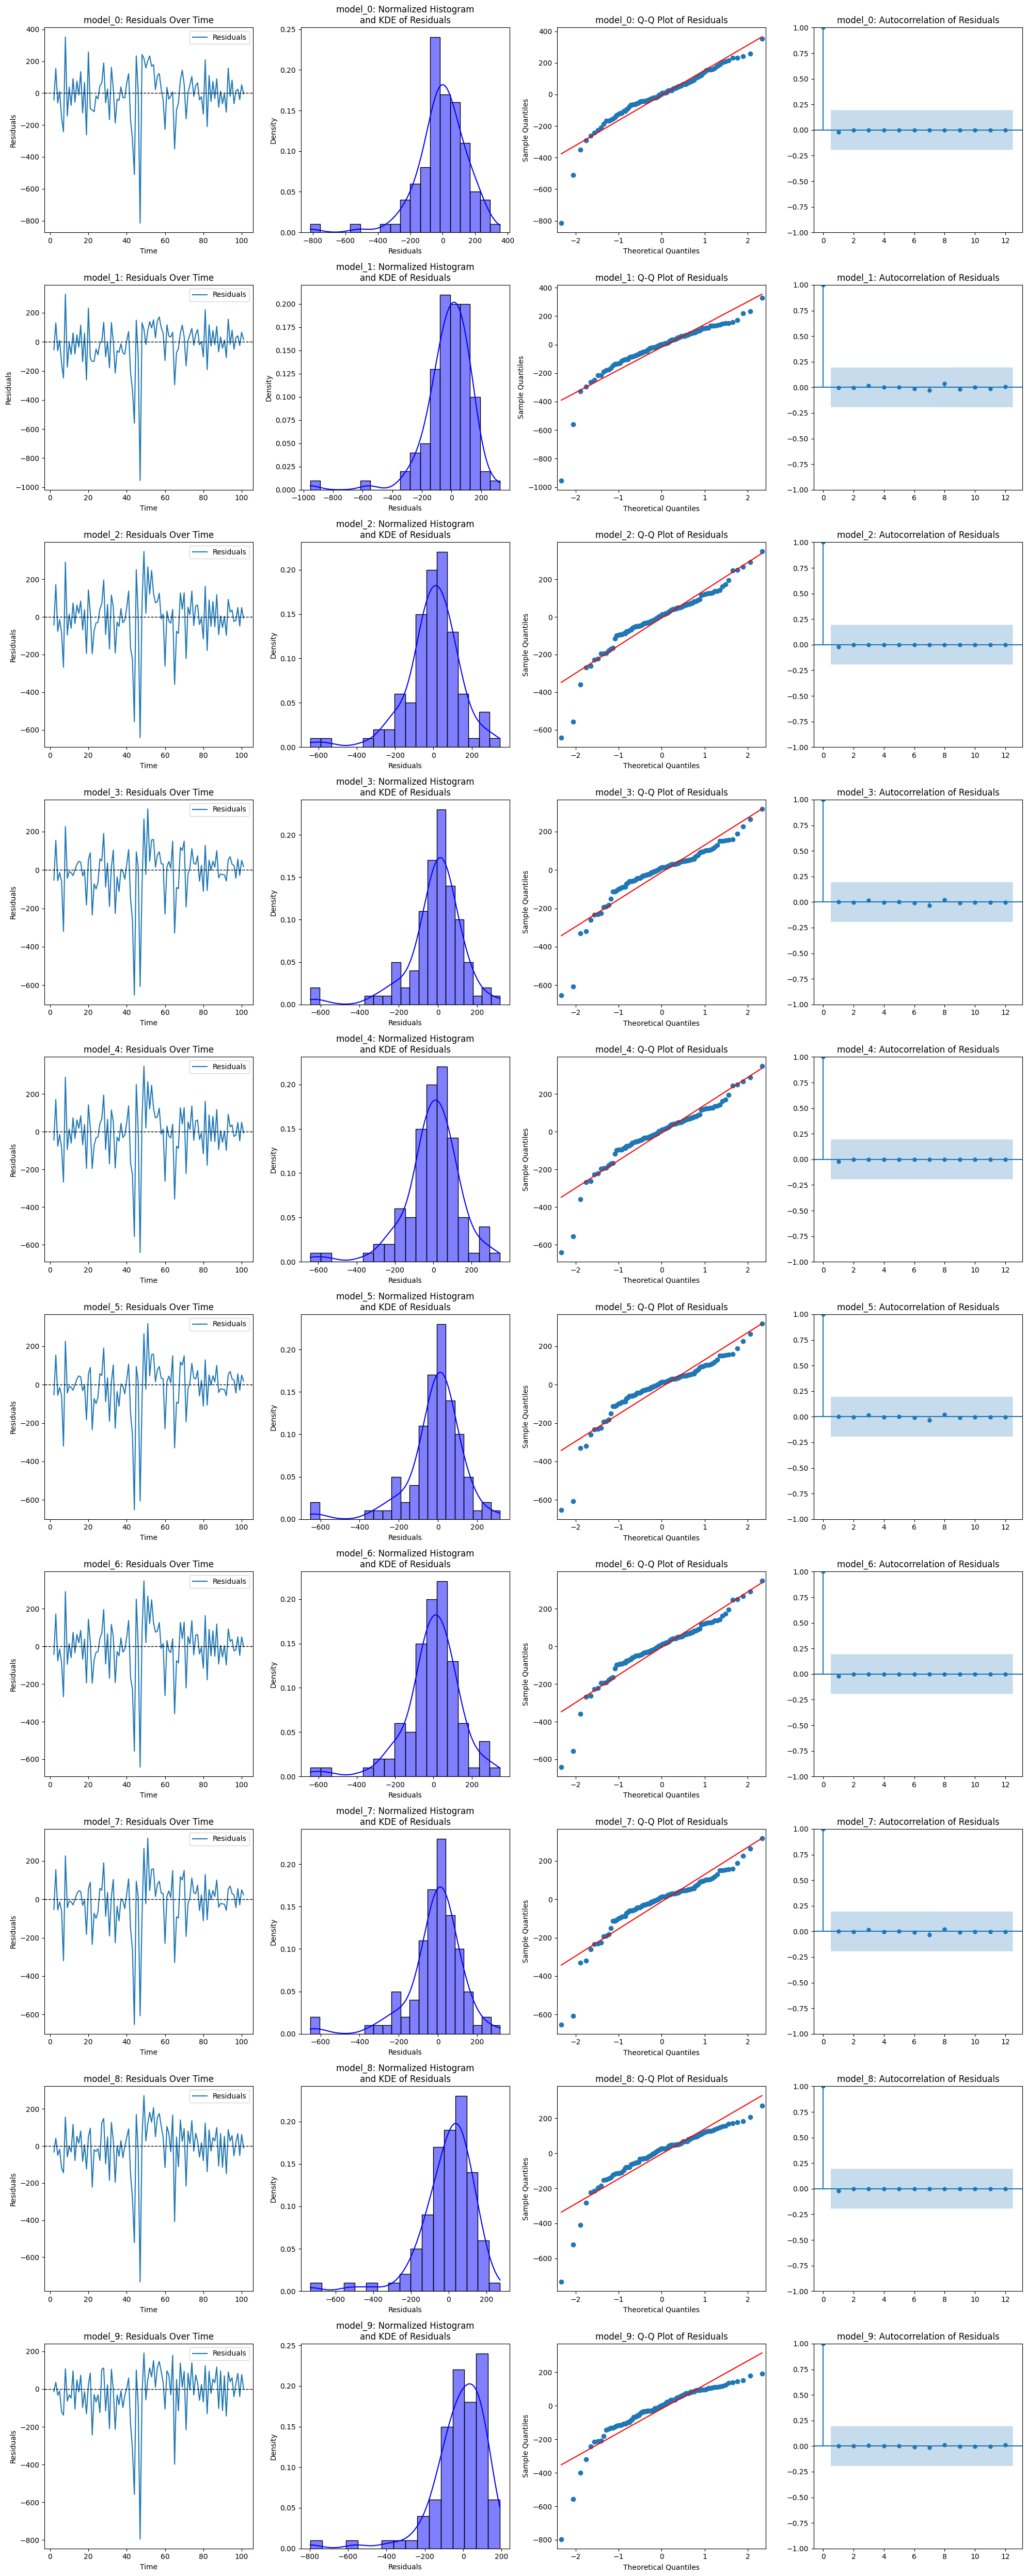

In [47]:
#plot residuals diagnostics
fig, axs = plt.subplots(len(list(adp_cv_results.keys())), 4, figsize=(20, 5 * len(list(adp_cv_results.keys()))))

data = joined_df['ADP'].dropna()
y = log_transform(data)

for i, (model_nm,model_params) in enumerate(adp_cv_results.items()):
    
    exog_vars = model_params['exog_vars']
    if exog_vars is None:
        exog = None
    else:
        exog = model_params['exog_signal']
    # elif exog_vars == 'admission_count' and (model_nm == 'model_1' or model_nm == 'model_2'):
    #     exog = exog_1
    # elif exog_vars == 'admission_count' and (model_nm == 'model_3' or model_nm == 'model_4'):
    #     exog = exog_2
    # else:
    #     exog = joined_df[exog_vars].dropna()
    #     # See how many points we may need to add to the exog signal
    #     diff_n = len(y) - len(exog)
    #     missing_data = pd.DataFrame(columns=exog.columns)
    #     for var in exog_vars:
    #         missing_data[var] = arrest_cv_models[var]['predictions'][0:diff_n]
    #     exog = pd.concat([exog, missing_data], ignore_index=True)
    #     # Ensure the exog variable has the same index as the target variable
    #     exog = log_transform(exog.loc[y.index]) 

    order = adp_cv_results[model_nm]['model params'][0]
    seasonal_order = adp_cv_results[model_nm]['model params'][1]

    model = SARIMAX(y, exog = exog, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
        
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    # Calculate residuals
    residuals = data - y_pred

    #plot residual diagnostics
    print(f'Computed the residuals for {model_nm}')
    # Residuals over time
    axs[i, 0].plot(residuals.index[2:], residuals[2:], label='Residuals')
    axs[i, 0].axhline(0, linestyle='--', color='black', linewidth=1)
    axs[i, 0].set_title(f'{model_nm}: Residuals Over Time')
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].set_ylabel('Residuals')
    axs[i, 0].legend()
    
    # Histogram and KDE plot of residuals
    sns.histplot(residuals[2:], kde=True,stat='probability', ax=axs[i, 1], color='blue')
    axs[i, 1].set_title(f'{model_nm}: Normalized Histogram\nand KDE of Residuals')
    axs[i, 1].set_xlabel('Residuals')
    axs[i, 1].set_ylabel('Density')
    
    # Q-Q plot of residuals
    sm.qqplot(residuals[2:], line='s', ax=axs[i, 2])
    axs[i, 2].set_title(f'{model_nm}: Q-Q Plot of Residuals')
    
    # ACF plot of residuals
    sm.graphics.tsa.plot_acf(residuals, lags=12, ax=axs[i, 3])
    axs[i, 3].set_title(f'{model_nm}: Autocorrelation of Residuals')
    print(f'Done plotting subplots for {model_nm}')
# Adjust layout to avoid overlapping
plt.tight_layout()
plt.savefig('../Outputs/adp_predictions_residual_plots.png', bbox_inches = 'tight')
plt.show()

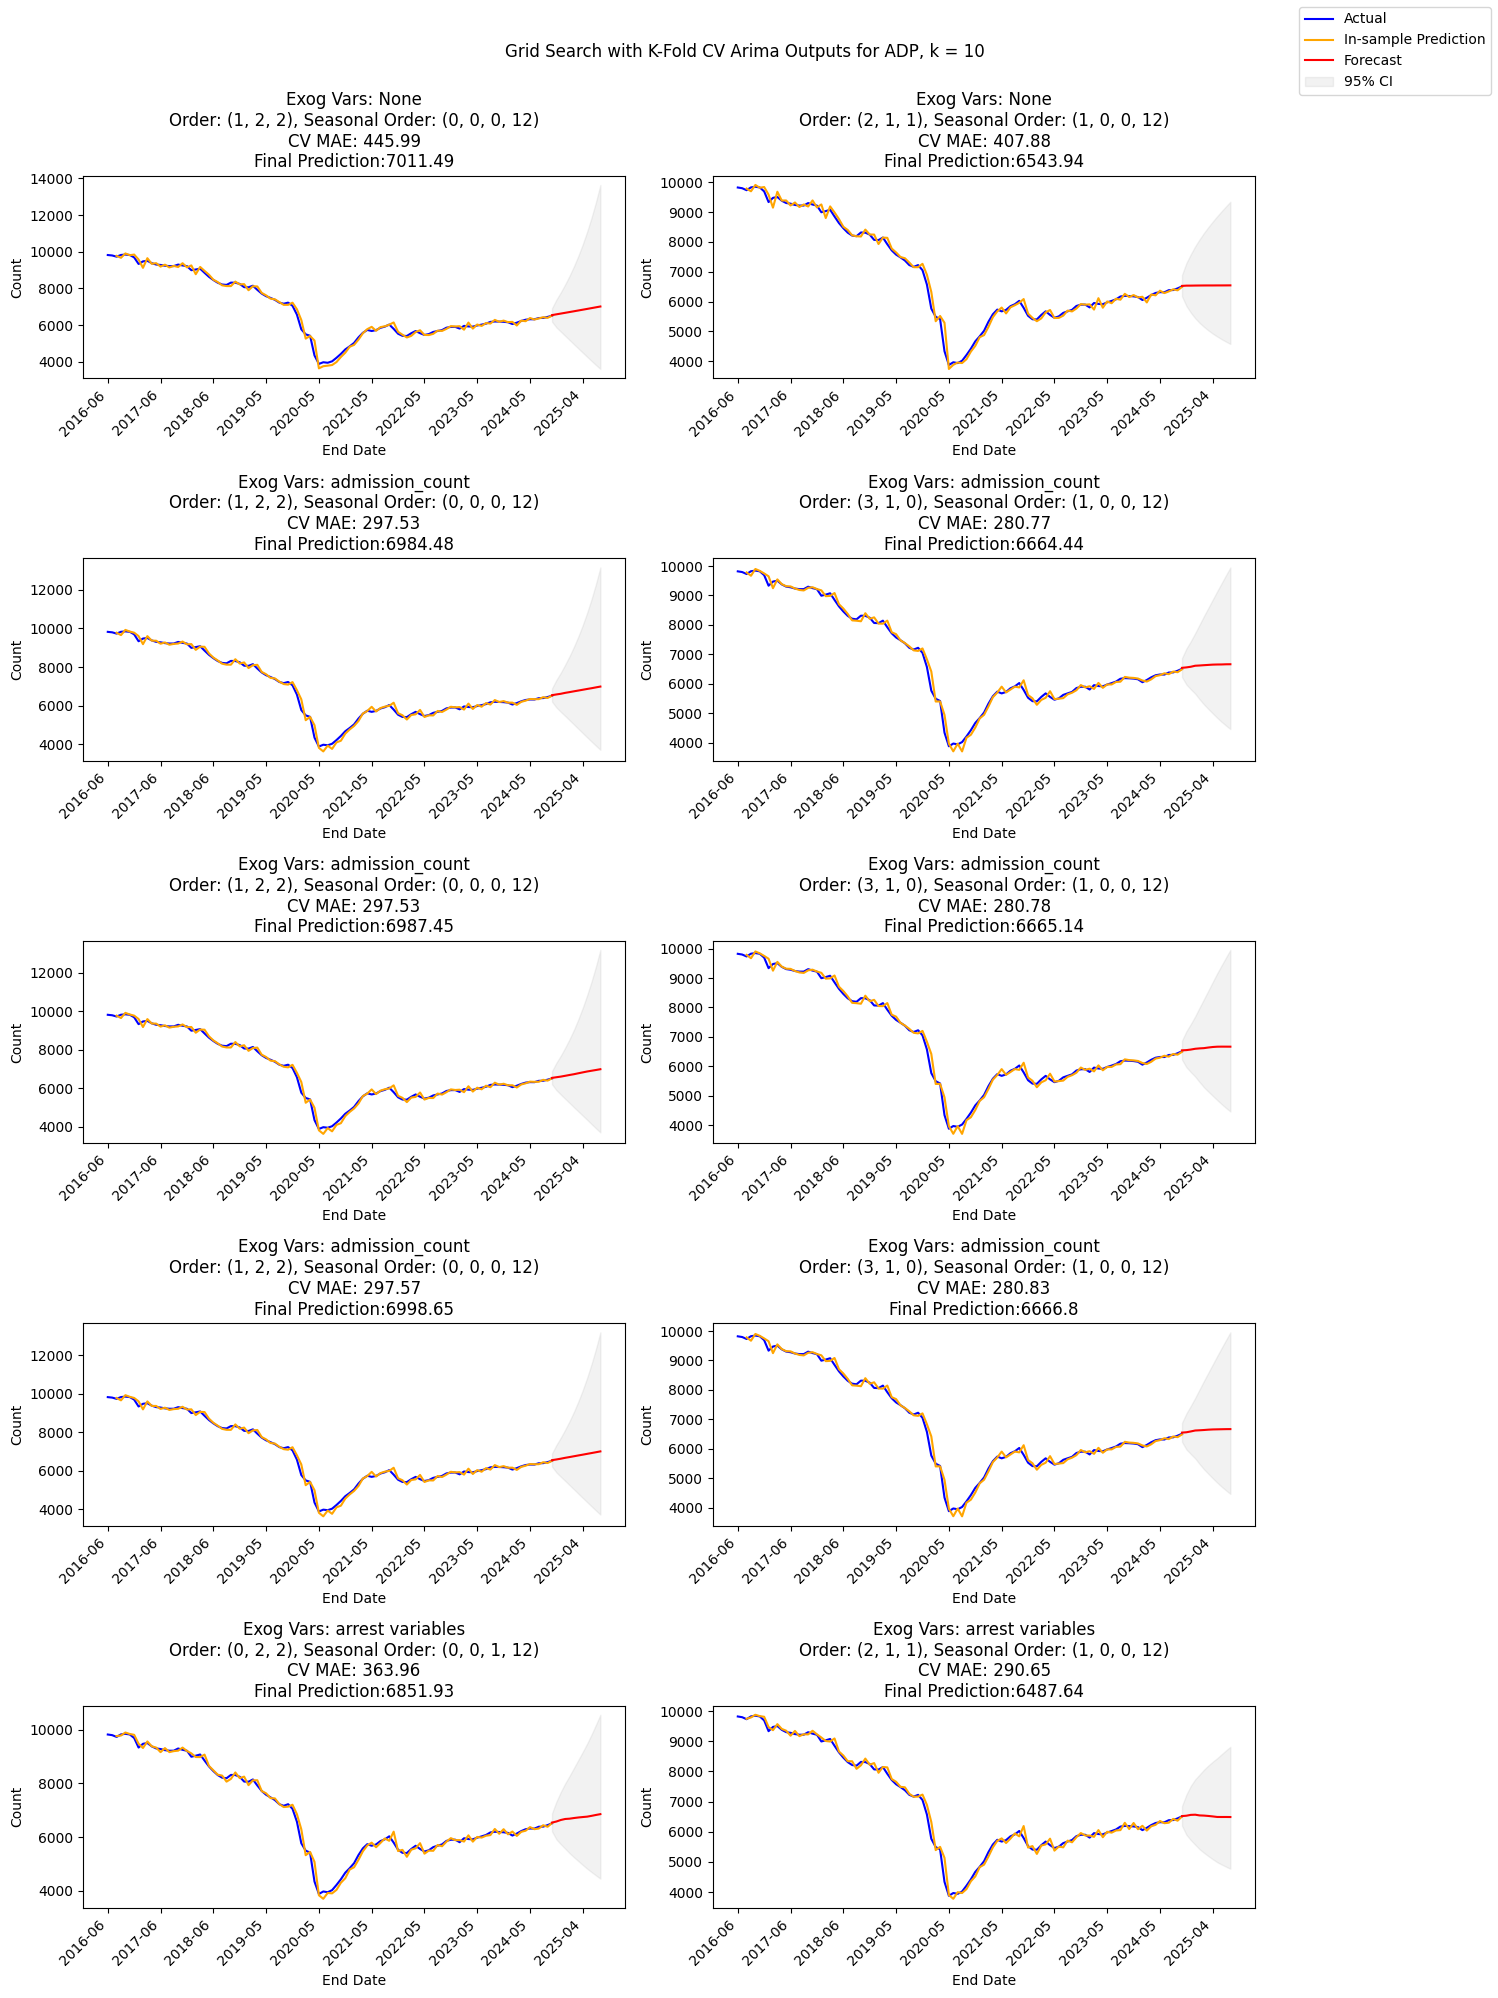

In [48]:
#plot the outputs
# Set up the subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

data = joined_df[['End Date','ADP']].dropna()
y = log_transform(data['ADP'])
diff_n_adm = len(y) - len(joined_df['admission_count'].dropna())
diff_n_arr = len(y) - len(joined_df['total_felony_arrest'].dropna())

for i, (model_nm,model_params) in enumerate(adp_cv_results.items()):
    ax = axes[i]

    exog_vars = model_params['exog_vars']

    if exog_vars is None:
        exog = None
        future_exog = None
    else:
        exog = model_params['exog_signal']

    if exog_vars == 'admission_count' and (model_nm == 'model_2' or model_nm == 'model_3'):
        future_exog = log_transform(adm_cv_models[f'model_0']['prediction'][diff_n_adm:])
    elif exog_vars == 'admission_count' and (model_nm == 'model_4' or model_nm == 'model_5'):
        future_exog = log_transform(adm_cv_models[f'model_3']['prediction'][diff_n_adm:])
    elif exog_vars == 'admission_count' and (model_nm == 'model_6' or model_nm == 'model_7'):
        future_exog = log_transform(adm_cv_models[f'model_1']['prediction'][diff_n_adm:])
    elif exog_vars != 'admission_count' and exog_vars is not None:
        future_exog = pd.DataFrame(columns = exog.columns, index = np.arange(len(exog),len(exog)+n_steps_adp))
        title_exog_str = 'arrest variables'
    
        for var in exog.columns:
            future_exog[var] = arrest_cv_models[var]['predictions'][diff_n_arr:]
        future_exog = log_transform(future_exog) 

    order = adp_cv_results[model_nm]['model params'][0]
    seasonal_order = adp_cv_results[model_nm]['model params'][1]
    cv_mae = adp_cv_results[model_nm]['mae']
    
    model = SARIMAX(y, exog = exog, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    #in sample
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    #predictions
    forecast_log = results.get_forecast(steps=n_steps_adp, exog=future_exog)
    forecast_mean_log = forecast_log.predicted_mean
    conf_int_log = forecast_log.conf_int()

    # Bias-adjusted mean forecast back-transformation
    forecast = inverse_log_transform(forecast_mean_log)
    adp_cv_results[model_nm]['prediction'] = forecast.values
    # Back-transform confidence intervals
    lower_bound = inverse_log_transform(conf_int_log.iloc[:, 0])
    upper_bound = inverse_log_transform(conf_int_log.iloc[:, 1])

    IS_mae = mean_absolute_error(data['ADP'].iloc[1:],y_pred.iloc[1:])

    # Plot the actual data
    ax.plot(data['End Date'], data['ADP'], label='Actual', color='blue')

    # Plot the in-sample prediction
    ax.plot(data['End Date'].iloc[2:], y_pred[2:], label='In-sample Prediction', color='orange')

    # Plot the forecast
    future_dates = pd.date_range(start=data['End Date'].iloc[-1], periods=n_steps_adp, freq='30D')
    ax.plot(future_dates, forecast, label='Forecast', color='red')

    # Plot the confidence intervals
    ax.fill_between(future_dates, lower_bound, upper_bound, color='grey', alpha=0.1, label='95% CI')
    
    # Set title and labels, including model parameters
    if exog_vars != 'admission_count' and exog_vars is not None:
        title = f"Exog Vars: {title_exog_str}\nOrder: {order}, Seasonal Order: {seasonal_order}\nCV MAE: {round(cv_mae,2)}\nFinal Prediction:{round(forecast.values[-1],2)}"
    else:
        title = f"Exog Vars: {exog_vars}\nOrder: {order}, Seasonal Order: {seasonal_order}\nCV MAE: {round(cv_mae,2)}\nFinal Prediction:{round(forecast.values[-1],2)}"
    ax.set_title(title)
    ax.set_xlabel('End Date')
    ax.set_ylabel('Count')

    # Set x-ticks and rotate labels
    dates = pd.date_range(start=data['End Date'].iloc[0], periods=len(data)+n_steps_adp, freq='30D')

    ax.set_xticks(dates[::12])
    ax.set_xticklabels(dates[::12].strftime('%Y-%m'), rotation=45, ha='right')

# Create a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle(f"Grid Search with K-Fold CV Arima Outputs for ADP, k = {n_splits}")

# Adjust layout
plt.tight_layout(rect=[0, 0, .85, .98])  # Leave space on the right for the legend
plt.savefig("../Outputs/grid_search_kfold_cv_adp_predictions_95CI.png", bbox_inches = 'tight')
plt.show()

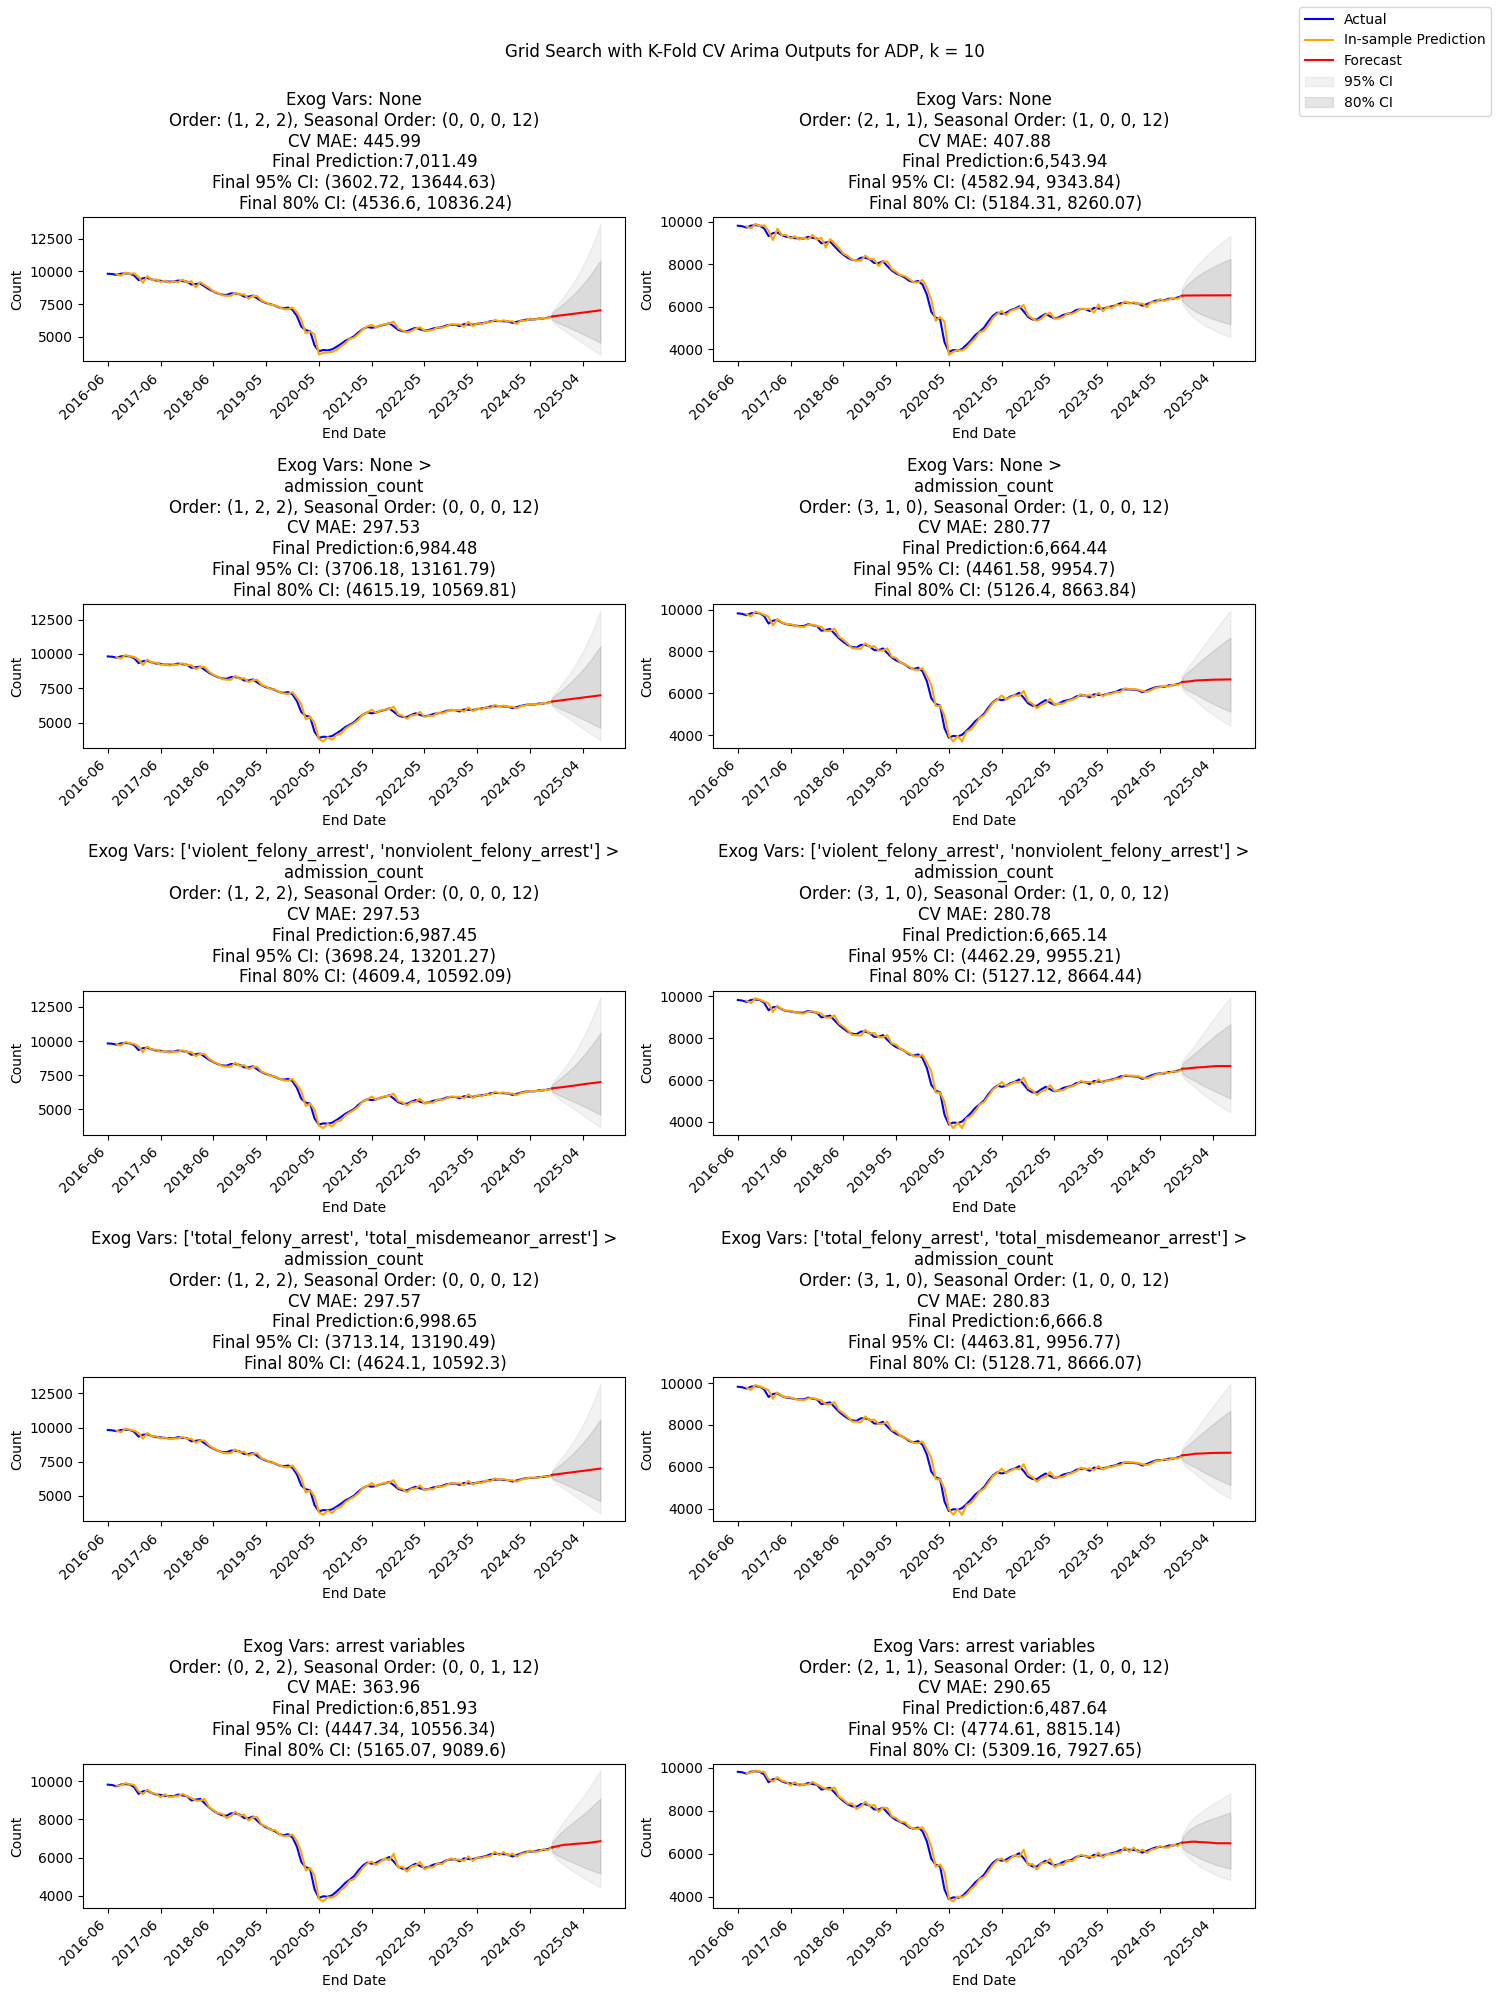

In [49]:
#plot with 80% CI
# Set up the subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

data = joined_df[['End Date','ADP']].dropna()
y = log_transform(data['ADP'])
diff_n_adm = len(y) - len(joined_df['admission_count'].dropna())
diff_n_arr = len(y) - len(joined_df['total_felony_arrest'].dropna())

for i, (model_nm,model_params) in enumerate(adp_cv_results.items()):
    ax = axes[i]

    exog_vars = model_params['exog_vars']

    if exog_vars is None:
        exog = None
        future_exog = None
    else:
        exog = model_params['exog_signal']

    if exog_vars == 'admission_count' and (model_nm == 'model_2' or model_nm == 'model_3'):
        future_exog = log_transform(adm_cv_models[f'model_0']['prediction'][diff_n_adm:])
        adm_exog_str = adm_cv_models[f'model_0']['exog_vars']
    elif exog_vars == 'admission_count' and (model_nm == 'model_4' or model_nm == 'model_5'):
        future_exog = log_transform(adm_cv_models[f'model_3']['prediction'][diff_n_adm:])
        adm_exog_str = adm_cv_models[f'model_3']['exog_vars']
    elif exog_vars == 'admission_count' and (model_nm == 'model_6' or model_nm == 'model_7'):
        future_exog = log_transform(adm_cv_models[f'model_1']['prediction'][diff_n_adm:])
        adm_exog_str = adm_cv_models[f'model_1']['exog_vars']
    elif exog_vars != 'admission_count' and exog_vars is not None:
        future_exog = pd.DataFrame(columns = exog.columns, index = np.arange(len(exog),len(exog)+n_steps_adp))
        title_exog_str = 'arrest variables'
        for var in exog.columns:
            future_exog[var] = arrest_cv_models[var]['predictions'][diff_n_arr:]
        future_exog = log_transform(future_exog) 

    order = adp_cv_results[model_nm]['model params'][0]
    seasonal_order = adp_cv_results[model_nm]['model params'][1]
    cv_mae = adp_cv_results[model_nm]['mae']
    
    model = SARIMAX(y, exog = exog, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    #in sample
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    #predictions
    forecast_log = results.get_forecast(steps=n_steps_adp, exog=future_exog)
    forecast_mean_log = forecast_log.predicted_mean
    conf_int_95_log = forecast_log.conf_int(alpha=0.05)  # 95% CI
    conf_int_80_log = forecast_log.conf_int(alpha=0.20)  # 80% CI

    # Bias-adjusted mean forecast back-transformation
    forecast = inverse_log_transform(forecast_mean_log)
    adp_cv_results[model_nm]['prediction'] = forecast.values
    # Back-transform confidence intervals
    lower_bound_95 = inverse_log_transform(conf_int_95_log.iloc[:, 0])
    upper_bound_95 = inverse_log_transform(conf_int_95_log.iloc[:, 1])

    lower_bound_80 = inverse_log_transform(conf_int_80_log.iloc[:, 0])
    upper_bound_80 = inverse_log_transform(conf_int_80_log.iloc[:, 1])

    IS_mae = mean_absolute_error(data['ADP'].iloc[1:],y_pred.iloc[1:])

    # Plot the actual data
    ax.plot(data['End Date'], data['ADP'], label='Actual', color='blue')

    # Plot the in-sample prediction
    ax.plot(data['End Date'].iloc[2:], y_pred[2:], label='In-sample Prediction', color='orange')

    # Plot the forecast
    future_dates = pd.date_range(start=data['End Date'].iloc[-1], periods=n_steps_adp, freq='30D')
    ax.plot(future_dates, forecast, label='Forecast', color='red')

    # Plot the 95% confidence intervals
    ax.fill_between(future_dates, lower_bound_95, upper_bound_95, color='grey', alpha=0.1, label='95% CI')

    # Plot the 80% confidence intervals on top of the 95% CI
    ax.fill_between(future_dates, lower_bound_80, upper_bound_80, color='grey', alpha=0.2, label='80% CI')

    # Set title and labels, including model parameters
    if exog_vars == 'admission_count':
        title = f"""Exog Vars: {adm_exog_str} >\n{exog_vars}\nOrder: {order}, Seasonal Order: {seasonal_order}\nCV MAE: {round(cv_mae,2)}
        Final Prediction:{round(forecast.values[-1],2):,g}\nFinal 95% CI: {round(lower_bound_95.iloc[-1],2), round(upper_bound_95.iloc[-1],2)}
        Final 80% CI: {round(lower_bound_80.iloc[-1],2), round(upper_bound_80.iloc[-1],2)}"""
    elif exog_vars != 'admission_count' and exog_vars is not None:
        title = f"""Exog Vars: {title_exog_str}\nOrder: {order}, Seasonal Order: {seasonal_order}\nCV MAE: {round(cv_mae,2)}
        Final Prediction:{round(forecast.values[-1],2):,g}\nFinal 95% CI: {round(lower_bound_95.iloc[-1],2), round(upper_bound_95.iloc[-1],2)}
        Final 80% CI: {round(lower_bound_80.iloc[-1],2), round(upper_bound_80.iloc[-1],2)}"""
    else:
        title = f"""Exog Vars: {exog_vars}\nOrder: {order}, Seasonal Order: {seasonal_order}\nCV MAE: {round(cv_mae,2)}
        Final Prediction:{round(forecast.values[-1],2):,g}\nFinal 95% CI: {round(lower_bound_95.iloc[-1],2), round(upper_bound_95.iloc[-1],2)}
        Final 80% CI: {round(lower_bound_80.iloc[-1],2), round(upper_bound_80.iloc[-1],2)}"""
    ax.set_title(title)
    ax.set_xlabel('End Date')
    ax.set_ylabel('Count')

    # Set x-ticks and rotate labels
    dates = pd.date_range(start=data['End Date'].iloc[0], periods=len(data)+n_steps_adp, freq='30D')

    ax.set_xticks(dates[::12])
    ax.set_xticklabels(dates[::12].strftime('%Y-%m'), rotation=45, ha='right')

# Create a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle(f"Grid Search with K-Fold CV Arima Outputs for ADP, k = {n_splits}")

# Adjust layout
plt.tight_layout(rect=[0, 0, .85, .98])  # Leave space on the right for the legend
plt.savefig("../Outputs/grid_search_kfold_cv_adp_predictions_95_80CI.png", bbox_inches = 'tight')
plt.show()

The final model that I am going to pick is the model with crime and arrest exogenous variables (row 5, column 2). Therefore the final SARIMAX parameters for the models needed are as follows:

total_misdemeanor_crimes: (0, 1, 3), (1, 0, 0, 12)

violent_felony_crimes: (1, 0, 0), (1, 0, 1, 12)

nonviolent_felony_crimes: (2, 1, 2), (1, 0, 0, 12)

total_misdemeanor_arrest: (2, 1, 2), (1, 0, 0, 12)

violent_felony_arrest: (3, 1, 0), (0, 0, 1, 12)

nonviolent_felony_arrest: (3, 1, 1), (1, 0, 1, 12)

ADP: (3,1,2)(1,0,1,12)

Let's check this model's results since it is not included in the lastest run of this notebook. 


In [55]:
#predict crime
crime_dict = {'total_misdemeanor_crimes':{'order':(0,1,3),'seasonal_order':(1,0,0,12)},
              'nonviolent_felony_crimes':{'order':(2,1,2),'seasonal_order':(1,0,0,12)},
              'violent_felony_crimes':{'order':(1,0,0),'seasonal_order':(1,0,1,12)}}

# Plot each crime keyiable
for key,params in crime_dict.items():
    data = crime_df[key].dropna()
    y = log_transform(data)
    order = crime_dict[key]['order']
    seasonal_order = crime_dict[key]['seasonal_order']
    model = SARIMAX(y, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
        
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    # Generate out-of-sample forecast_exog
    forecast_log = results.get_forecast(steps=n_steps_crime)
    y_forecast_log = forecast_log.predicted_mean
    conf_int_log = forecast_log.conf_int()

    # Bias-adjusted mean forecast back-transformation
    forecast = inverse_log_transform(y_forecast_log)
    #store in dictionary
    crime_dict[key]['predictions'] = forecast.values

crime_dict

{'total_misdemeanor_crimes': {'order': (0, 1, 3),
  'seasonal_order': (1, 0, 0, 12),
  'predictions': array([24137.30037773, 23918.65891377, 23845.13674026, 23634.47727592,
         23812.03589884, 23574.4462413 , 23112.13928016, 23723.89704097,
         23808.56935655, 23683.72476678, 23825.6393261 , 24010.2291177 ,
         23980.32630132, 23927.18786142, 23909.23657714, 23857.56882397])},
 'nonviolent_felony_crimes': {'order': (2, 1, 2),
  'seasonal_order': (1, 0, 0, 12),
  'predictions': array([10985.28752023, 10995.02286936, 10983.0188942 , 10907.39712227,
         10872.40772509, 10693.82462852, 10488.8291927 , 10834.72605659,
         10728.12813448, 10729.54309701, 10772.74076159, 10803.96795066,
         10834.13804978, 10836.71913531, 10833.95036219, 10815.61487632])},
 'violent_felony_crimes': {'order': (1, 0, 0),
  'seasonal_order': (1, 0, 1, 12),
  'predictions': array([4307.35454808, 4270.10859578, 4135.20429558, 4086.23903567,
         3935.09567581, 3814.68380577, 3697.

In [56]:
#predict arrests
arrest_dict = {'total_misdemeanor_arrest':{'order':(2,1,2),'seasonal_order':(1,0,0,12), 'exog':'total_misdemeanor_crimes'},
              'nonviolent_felony_arrest':{'order':(3,1,1),'seasonal_order':(1,0,1,12), 'exog':'nonviolent_felony_crimes'},
              'violent_felony_arrest':{'order':(3,1,0),'seasonal_order':(0,0,1,12), 'exog':'violent_felony_crimes'}}

for key, params in arrest_dict.items():
    data = arrest_df[key].dropna()
    exog_var = params['exog']
    exog = log_transform(crime_df[exog_var].dropna())
    y = log_transform(data)
    # Ensure the exog keyiable has the same index as the target keyiable
    exog = exog.loc[y.index]

    order = params['order']
    seasonal_order = params['seasonal_order']

    model = SARIMAX(y,exog = exog, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    
    #get exog_preds
    exog_forecast = crime_dict[exog_var]['predictions']
    exog_forecast_log = log_transform(exog_forecast)
    
    #now predict target var
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    # Generate out-of-sample forecast_exog
    forecast_log = results.get_forecast(steps=n_steps_arr, exog = exog_forecast_log)
    y_forecast_log = forecast_log.predicted_mean
    conf_int_log = forecast_log.conf_int()

    # Bias-adjusted mean forecast back-transformation
    forecast = inverse_log_transform(y_forecast_log)

    #store in dictionary
    arrest_dict[key]['predictions'] = forecast.values

arrest_dict


{'total_misdemeanor_arrest': {'order': (2, 1, 2),
  'seasonal_order': (1, 0, 0, 12),
  'exog': 'total_misdemeanor_crimes',
  'predictions': array([11735.40725241, 11404.58485011, 11452.65344876, 11483.7189073 ,
         11612.47260005, 11547.72429522, 11335.75023954, 11968.26604733,
         11895.50033833, 11841.70714565, 11946.39172967, 11995.41949678,
         11925.69113061, 11848.69815732, 11856.93567226, 11856.54165094])},
 'nonviolent_felony_arrest': {'order': (3, 1, 1),
  'seasonal_order': (1, 0, 1, 12),
  'exog': 'nonviolent_felony_crimes',
  'predictions': array([5729.58509014, 5734.15273431, 5733.49748935, 5888.74341304,
         5879.40009012, 5620.93615411, 5584.29613028, 6091.7237886 ,
         6141.64267382, 5990.06295582, 6015.66529561, 5949.66933274,
         5784.71617728, 5817.60881817, 5832.87478192, 5983.05939747])},
 'violent_felony_arrest': {'order': (3, 1, 0),
  'seasonal_order': (0, 0, 1, 12),
  'exog': 'violent_felony_crimes',
  'predictions': array([3093.1315

In [67]:
#predict adp
order = (3,1,2)
seasonal_order = (1,0,1,12)

#determine prediction size for each consecutive iteration based on 12 mo future predicts plus any missing data
missing_n_arrest = 0 if len(joined_df['ADP'].dropna()) < len(arrest_df.dropna()) else len(joined_df['ADP'].dropna()) - len(arrest_df.dropna())
#rolling window method to obtain CV MAE
exog = pd.DataFrame({
    'total_misdemeanor_arrest': pd.concat([arrest_df['total_misdemeanor_arrest'].dropna(),pd.Series(arrest_dict['total_misdemeanor_arrest']['predictions'][:missing_n_arrest])],ignore_index=True).values,
    'nonviolent_felony_arrest': pd.concat([arrest_df['nonviolent_felony_arrest'].dropna(),pd.Series(arrest_dict['nonviolent_felony_arrest']['predictions'][:missing_n_arrest])],ignore_index=True).values,
    'violent_felony_arrest': pd.concat([arrest_df['violent_felony_arrest'].dropna(),pd.Series(arrest_dict['violent_felony_arrest']['predictions'][:missing_n_arrest])],ignore_index=True).values
})
exog_log = log_transform(exog)
y = joined_df['ADP'].dropna()
y = log_transform(y)

results, mae_score = time_series_cv(y, order=order, seasonal_order=seasonal_order, n_splits=10, exog=exog_log)

print(mae_score)
print(results.summary())

298.0108226589332
                                      SARIMAX Results                                       
Dep. Variable:                                  ADP   No. Observations:                   93
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood                 206.577
Date:                              Sun, 06 Oct 2024   AIC                           -391.154
Time:                                      09:54:43   BIC                           -363.414
Sample:                                           0   HQIC                          -379.958
                                               - 93                                         
Covariance Type:                                opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
total_misdemeanor_arrest     0.1049      0.065      

In [74]:
arrest_dict

{'total_misdemeanor_arrest': {'order': (2, 1, 2),
  'seasonal_order': (1, 0, 0, 12),
  'exog': 'total_misdemeanor_crimes',
  'predictions': array([11735.40725241, 11404.58485011, 11452.65344876, 11483.7189073 ,
         11612.47260005, 11547.72429522, 11335.75023954, 11968.26604733,
         11895.50033833, 11841.70714565, 11946.39172967, 11995.41949678,
         11925.69113061, 11848.69815732, 11856.93567226, 11856.54165094])},
 'nonviolent_felony_arrest': {'order': (3, 1, 1),
  'seasonal_order': (1, 0, 1, 12),
  'exog': 'nonviolent_felony_crimes',
  'predictions': array([5729.58509014, 5734.15273431, 5733.49748935, 5888.74341304,
         5879.40009012, 5620.93615411, 5584.29613028, 6091.7237886 ,
         6141.64267382, 5990.06295582, 6015.66529561, 5949.66933274,
         5784.71617728, 5817.60881817, 5832.87478192, 5983.05939747])},
 'violent_felony_arrest': {'order': (3, 1, 0),
  'seasonal_order': (0, 0, 1, 12),
  'exog': 'violent_felony_crimes',
  'predictions': array([3093.1315

In [85]:
#get final forecast and 95% CI
#predict adp
order = (3,1,2)
seasonal_order = (1,0,1,12)

#determine prediction size for each consecutive iteration based on 12 mo future predicts plus any missing data
missing_n_arrest = 0 if len(joined_df['ADP'].dropna()) < len(arrest_df.dropna()) else len(joined_df['ADP'].dropna()) - len(arrest_df.dropna())
#rolling window method to obtain CV MAE
exog = pd.DataFrame({
    'total_misdemeanor_arrest': pd.concat([arrest_df['total_misdemeanor_arrest'].dropna(),pd.Series(arrest_dict['total_misdemeanor_arrest']['predictions'][:missing_n_arrest])],ignore_index=True).values,
    'nonviolent_felony_arrest': pd.concat([arrest_df['nonviolent_felony_arrest'].dropna(),pd.Series(arrest_dict['nonviolent_felony_arrest']['predictions'][:missing_n_arrest])],ignore_index=True).values,
    'violent_felony_arrest': pd.concat([arrest_df['violent_felony_arrest'].dropna(),pd.Series(arrest_dict['violent_felony_arrest']['predictions'][:missing_n_arrest])],ignore_index=True).values
})
exog_log = log_transform(exog)
y = joined_df['ADP'].dropna()
y = log_transform(y)

model = SARIMAX(y,exog = exog, order=order, seasonal_order=seasonal_order)
results = model.fit(disp=False)

#get exog_preds
future_exog = pd.DataFrame(columns = exog.columns)

for var in exog.columns:
    future_exog[var] = arrest_dict[var]['predictions'][missing_n_arrest:]
exog_forecast_log = log_transform(future_exog)

#now predict target var
predictions = results.predict(start=y.index[0], end=y.index[-1])
y_pred = inverse_log_transform(predictions)
# Generate out-of-sample forecast_exog
forecast_log = results.get_forecast(steps=12, exog = exog_forecast_log)
y_forecast_log = forecast_log.predicted_mean
conf_int_log = forecast_log.conf_int()
lower_bound_95 = inverse_log_transform(conf_int_log.iloc[:, 0])
upper_bound_95 = inverse_log_transform(conf_int_log.iloc[:, 1])

# Bias-adjusted mean forecast back-transformation
forecast = inverse_log_transform(y_forecast_log)

print('Final Prediction value is: ', forecast.iloc[-1])
print(f'Final Prediction CI is:  {[lower_bound_95.iloc[-1],upper_bound_95.iloc[-1]]}')


Final Prediction value is:  6370.499275070977
Final Prediction CI is:  [4226.793648290306, 9601.17228876503]


### Summary of Findings

We ran a handful of tests with a combination of exogenous variables and ARIMA parameters. I have summarized the findings in a table below.

| Total Misdemeanor Crimes | Total Felony Crimes | Nonviolent Felony Crimes | Violent Felony Crimes | Total Misdemeanor Arrests |Total Felony Arrests | Nonviolent Felony Arrests | Violent Felony Arrests | Admission Counts | Average Daily Jail Population | Rolling Window Average MAE | Final Prediction | 95% CI Lower Bound | 95% CI Upper Bound |
|--------------------------|--------------------------|--------------------------|-----------------------|---------------------------|---------------------------|---------------------------|------------------------|------------------|--------------------------------|----------------------------|------------------|---------------------|---------------------|
|None|None|None|None|None|None|None|None|None|(1,2,2)(0,0,0,12)|445.99|7,011|3,603|13,645|
|None|None|None|None|None|None|None|None|None|(2,1,1)(1,0,0,12)|407.88|6,544|4,583|9,344|
|None|None|None|None|None|None|None|None|(0,1,0)(1,0,1,12)|(1,2,2)(0,0,0,12)|297.53|6,984|3,706|13,162|
|None|None|None|None|None|None|None|None|(0,1,0)(1,0,1,12)|(3,1,0)(1,0,0,12)|280.77|6,664|4,462|9,955|
|None|None|(1,1,1)(1,0,0,12)|(1,0,2)(1,0,1,12)|None|None|(2, 1, 0)(1, 0, 0, 12)|(2, 1, 0)(0, 0, 1, 12)|(0, 1, 3)(0, 0, 0, 12)|(1,2,2)(0,0,0,12)|297.53|6,987|3,698|13,201|
|None|None|(1,1,1)(1,0,0,12)|(1,0,2)(1,0,1,12)|None|None|(2, 1, 0), (1, 0, 0, 12)|(2, 1, 0)(0, 0, 1, 12)|(0, 1, 3)(0, 0, 0, 12)|(3,1,0)(1,0,0,12)|280.78|6,665|4,462|9,955|
|(1, 1, 3)(0, 0, 0, 12)|(2, 1, 3)(1, 0, 1, 12)|None|None|(1, 1, 2)(1, 0, 0, 12)|(2, 1, 0)(1, 0, 0, 12)|None|None|(0, 1, 3)(0, 0, 0, 12)|(1,2,2)(0,0,0,12)|297.57|6,999|3,713|13,190|
|(1, 1, 3)(0, 0, 0, 12)|(2, 1, 3)(1, 0, 1, 12)|None|None|(1, 1, 2)(1, 0, 0, 12)|(2, 1, 0)(1, 0, 0, 12)|None|None|(0, 1, 3)(0, 0, 0, 12)|(3,1,0)(1,0,0,12)|280.83|6,667|4,464|9,957|
|(1, 1, 3)(0, 0, 0, 12)|None|(1,1,1)(1,0,0,12)|(1,0,2)(1,0,1,12)|(1, 1, 2)(1, 0, 0, 12)|None|(2, 1, 0)(1, 0, 0, 12)|(2, 1, 0)(0, 0, 1, 12)|None|(0,2,2)(0,0,1,12)|363.96|6,852|4,447|10,556|
|(1, 1, 3)(0, 0, 0, 12)|None|(1,1,1)(1,0,0,12)|(1,0,2)(1,0,1,12)|(1, 1, 2)(1, 0, 0, 12)|None|(2, 1, 0), (1, 0, 0, 12)|(2, 1, 0)(0, 0, 1, 12)|None|(2,1,1)(1,0,0,12)|290.65|6,488|4,775|8,815|
|(0, 1, 3)(1, 0, 0, 12)|None|(2,1,2)(1,0,0,12)|(1,0,0)(1,0,1,12)|(2, 1, 2)(1, 0, 0, 12)|None|(3, 1, 1), (1, 0, 1, 12)|(3, 1, 0)(0, 0, 1, 12)|None|(3,1,1)(1,0,1,12)|298.01|6,370|4,227|9,601|

